In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import joblib
from tqdm import tqdm
import pandas as pd
import argparse
import os
from scipy.stats import ortho_group

In [15]:
from main import weighted_l2, decode, PSNR, plot_data, load_ecg, load_train_ecg, load_test_ecg, create_pulse
max_signal_length = 100 # used in load_train_ecg and load_test_ecg to keep an integer multiple of patch_size number of samples  

In [16]:
# default values
# cnt is the number of plots to be saved for each (n_components, n_train, patch_size) tuple 
n_train, n_test, n_components, cnt = 10000, 1000, 5, 5
n_init, d, to_train, use_mat = 5, 30, True, False # d is the patch size

# for pulse
num_peaks = d//10
peak_width = 10

folder_name = 'results/n_components=%d,n_train=%d,patch_size=%d/' % (n_components, n_train, d)

In [17]:
def generate_covariance_matrices(n_components, d):
    ans = []
    for i in range(n_components):
        # k = (d//3) * 2 # something lesser than d
        # W = np.random.rand(d,k)
        # S = (W @ W.transpose()) + np.diag(np.random.rand(1,d) * 0.01)
        # S = np.diag(1/np.sqrt(np.diag(S))) @ S @ np.diag(1/np.sqrt(np.diag(S)))
        # ans.append(S)
        Q = ortho_group.rvs(d)
        decay = 0.47*(1 + np.random.random())
        eps = 1e-8
        U = np.ones(d,) * (np.random.rand() * 20) + 600
        for j in range(1,d):
            U[j] = max((U[j-1] * decay) + (np.random.rand() * 0.01), eps)
        ans.append(Q @ np.diag(U) @ Q.transpose())
    return np.array(ans)

In [18]:
gen_model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
# suppose we are training on n dimensional data

gen_model.weights_ = np.random.rand(n_components,)
gen_model.weights_ /= np.sum(gen_model.weights_)

gen_model.means_ = np.random.rand(n_components, d) * 80
gen_model.covariances_ = generate_covariance_matrices(n_components, d)

[0.0462799  0.26820421 0.24703729 0.3446322  0.0938464 ]
(5,)
(5, 30)
(5, 30, 30)


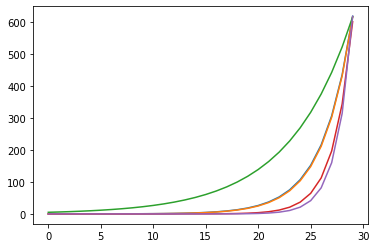

In [19]:
print(gen_model.weights_) # check if no single component gets majority of the weight 
print(gen_model.weights_.shape)
print(gen_model.means_.shape)
print(gen_model.covariances_.shape)

# sanity check of covariance matrix
for i in range(n_components):
    # asserting checks if matrix is positive definite
    assert(np.linalg.det(gen_model.covariances_[i,:,:]) > 0)
    plt.plot(np.linalg.eigvalsh(gen_model.covariances_[i,:,:]))
    
plt.show()

In [8]:
train_data,_ = gen_model.sample(n_train)
train_data.shape

(10000, 30)

In [9]:
# here one assumption is that we know the number of components, however this will have to be varied
model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
model.fit(train_data)

if os.path.isdir(folder_name):
    for f in os.listdir(folder_name):
        if not os.path.isdir(folder_name + f):
            os.remove(folder_name + f)
else:
    os.makedirs(folder_name)

# Save the model as a pickle in a file
joblib.dump(model, folder_name + 'model.pkl')

Initialization 0
Initialization converged: True
Initialization 1
  Iteration 10
Initialization converged: True
Initialization 2
Initialization converged: True
Initialization 3
Initialization converged: True
Initialization 4
Initialization converged: True


['results/n_components=5,n_train=10000,patch_size=30/model.pkl']

In [10]:
test_data,_ = gen_model.sample(n_test)
A_ = np.random.binomial(1, 0.5, size=(d, d))

ms = [d*(i+1)//10 for i in range(10)]
psnr, psnr_min, psnr_max, psnr_std = [], [], [], []
val_err, err_std = [], []

for m in tqdm(ms):
    if use_mat:
        A = np.load(folder_name + 'mat/%d.npy' % m)
    else:
        A = A_[:m, :]
    mm = (m*4)//5
    reconstruction = np.empty(test_data.shape)
    patch_err = []
    cnt1 = cnt
    for j in range(len(test_data)):
        x = test_data[j]
        x_hat = np.zeros(x.shape)
        for i in range(x.shape[0]//d):
            y = A @ x[i*d:(i+1)*d]
            x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
            patch_err.append(np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d]))
        # cs example
        if cnt1 > 0:
            plt.plot(x, label='Original', color = "C0")
            plt.plot(x_hat, label='Reconstructed', color = "C1")
            plt.legend()
            plt.savefig(folder_name + 'cs_%d_%d.png' % (cnt1, mm))
            plt.close()
            cnt1 -= 1
        reconstruction[j] = x_hat
    val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
    psnr.append(val)
    psnr_min.append(min_val)
    psnr_max.append(max_val)
    psnr_std.append(std_val)
    val_err.append(np.mean(patch_err))
    err_std.append(np.std(patch_err))

print(psnr)
print(psnr_std)
print(val_err)
print(err_std)
plot_data([x//5*4 for x in ms], psnr, path=folder_name + 'psnr.png')
plot_data([x//5*4 for x in ms], val_err, path=folder_name + 'val_err.png', ylabel='Validation error (1e-2)')

100%|██████████| 10/10 [01:10<00:00,  7.06s/it]


[21.121399846986563, 29.30616079735481, 32.318266758982844, 35.540568988214986, 39.257658030702544, 41.45635221068301, 43.16781517522734, 47.49534593547324, 50.218113942035856, 53.601954362753155]
[8.5273080138808, 4.700197566151045, 4.539777564695305, 5.346647556987928, 6.212177391747902, 6.932953846994755, 7.187484602104262, 7.604877906868332, 7.837202036073668, 8.179373544845852]
[71.47173525884939, 22.375026689702775, 16.00188647210467, 14.34694120046271, 7.589577274357951, 9.476861450678857, 9.919459311535636, 6.384750079912028, 5.1774325815021704, 3.447057735490161]
[70.47468073991428, 28.0717615355167, 13.106908522374006, 14.458515976863724, 8.336962538306656, 12.304618707424828, 12.979936942578579, 11.28012372554389, 10.134308253905074, 7.833125198853119]


# The following section would be to detect anomalies in the y domain
- we can use val error which is the mean of cross val errors for each measurent length
- let us detect drift based on the following condition

If 10 or more consecutive samples lie outside $E[e_{cv}] + 0.5V[e_{cv}]$ we will conclude that there is a drift in the generating distribution

10it [01:15,  7.52s/it]


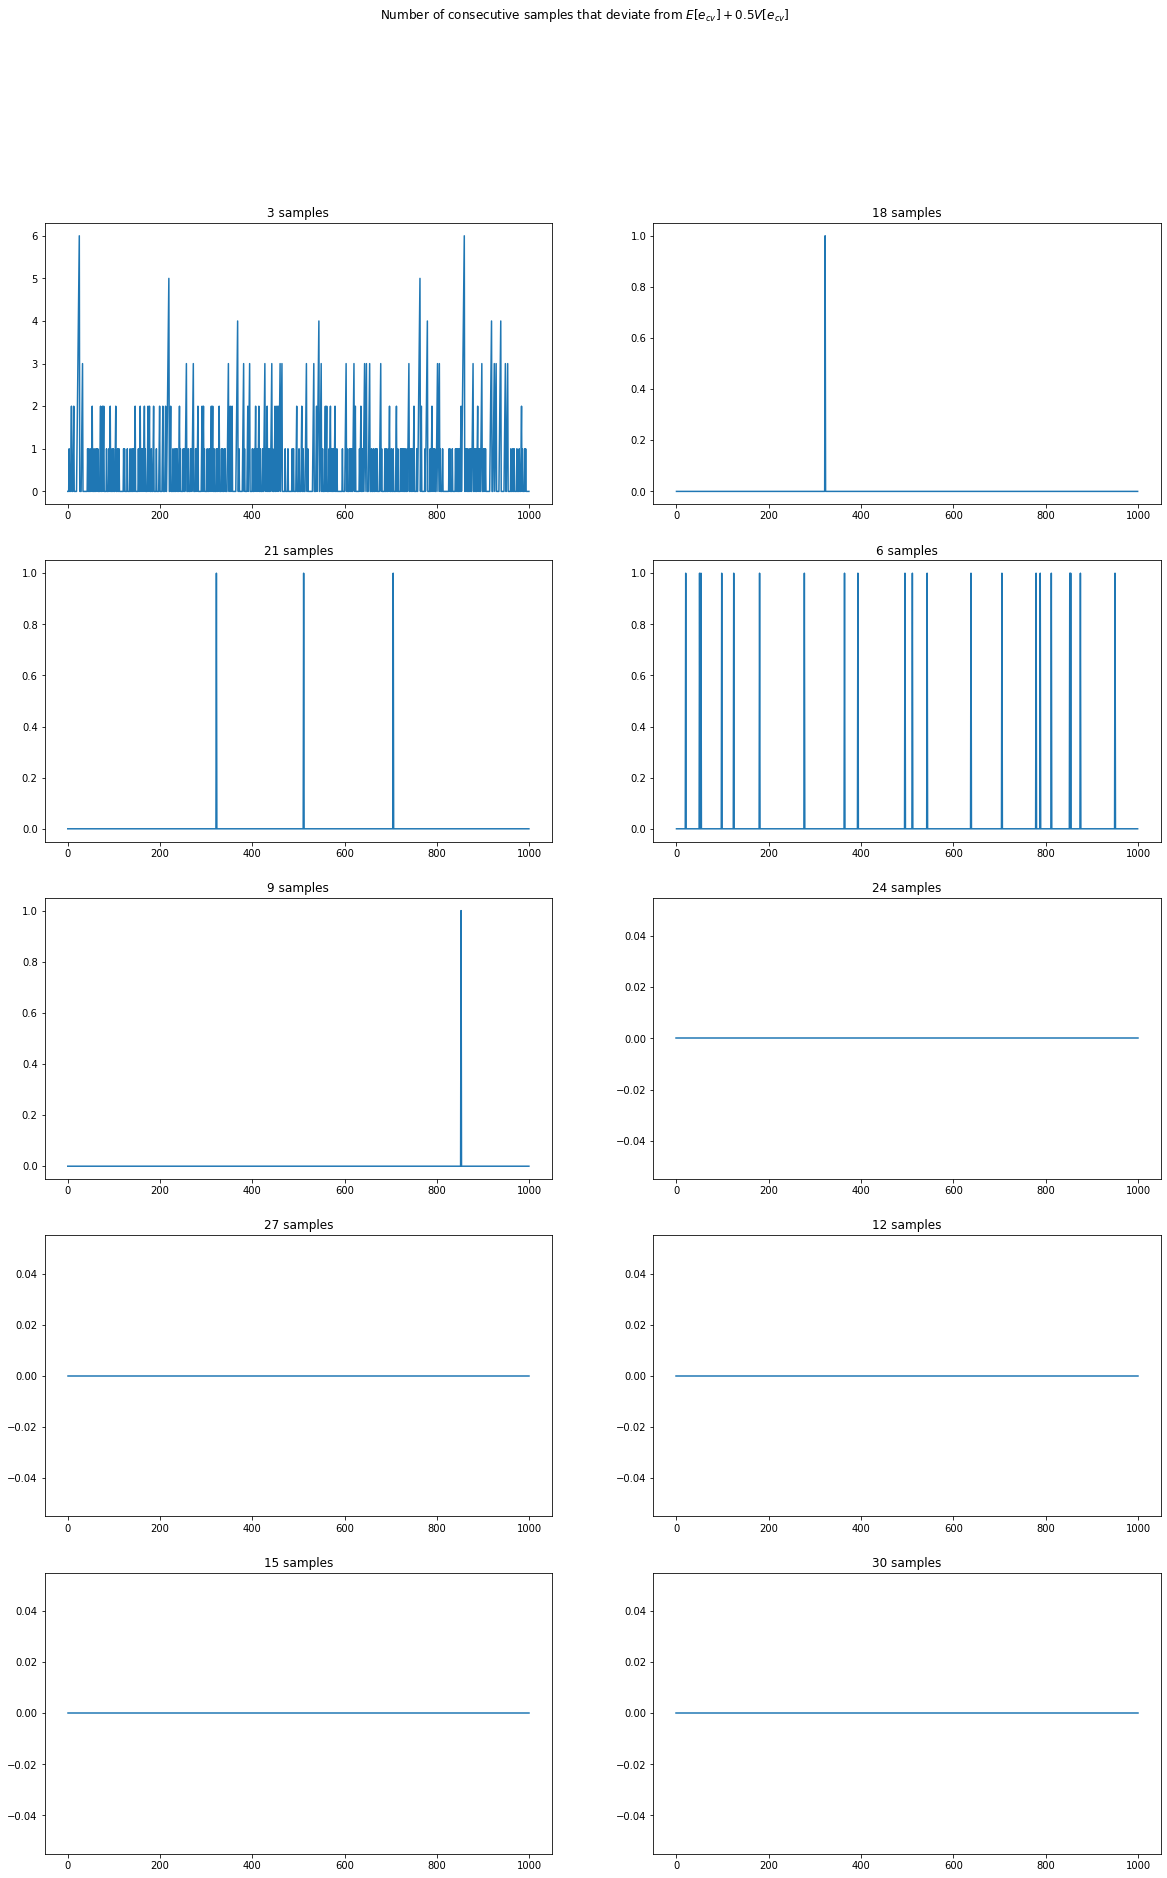

In [11]:
test_data,_ = gen_model.sample(n_test)
np.random.shuffle(test_data)
fig, ax = plt.subplots(5, 2, figsize=(20, 30))
fig.suptitle("Number of consecutive samples that deviate from $E[e_{cv}] + 0.5V[e_{cv}]$")
for iter,m in tqdm(enumerate(ms)):
    if use_mat:
        A = np.load(folder_name + 'mat/%d.npy' % m)
    else:
        A = A_[:m, :]
    mm = (m*4)//5
    dev_counts = []
    reconstruction = np.empty(test_data.shape)
    deviation_count = 0
    for j in range(len(test_data)):
        x = test_data[j]
        x_hat = np.zeros(x.shape)
        for i in range(x.shape[0]//d):
            y = A @ x[i*d:(i+1)*d]
            x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
            e_cv = np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d])
            if e_cv > (val_err[i] + 0.5*err_std[i]):
                deviation_count += 1
            else:
                deviation_count = 0
            dev_counts.append(deviation_count)
        reconstruction[j] = x_hat
    # val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
    ax[iter%5][iter%2].plot(dev_counts)
    ax[iter%5][iter%2].set_title('%d samples' % m)


plt.show()

# Observation
We observe that unless the number of measurements is too low (10%), it is very rare that the number of consecutive samples that deviate from <br> $E[e_{cv}] + 0.5V[e_{cv}]$ would be greater than 20. Hence, we can use this as a criteria to detect drift <br>
The following section intends to introduce a drift in the generating distribution intentionally to check whether our criteria was correct

In [12]:
# introduction on drift in the generating distribution
np.random.seed(42)
drift_model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
# suppose we are training on n dimensional data

drift_model.weights_ = gen_model.weights_
drift_model.means_ = gen_model.means_ + (gen_model.means_ * np.random.choice([-1,1]) * (0.2 + 0.2*(np.random.rand())))
drift_model.covariances_ = generate_covariance_matrices(n_components, d)

10it [01:26,  8.68s/it]


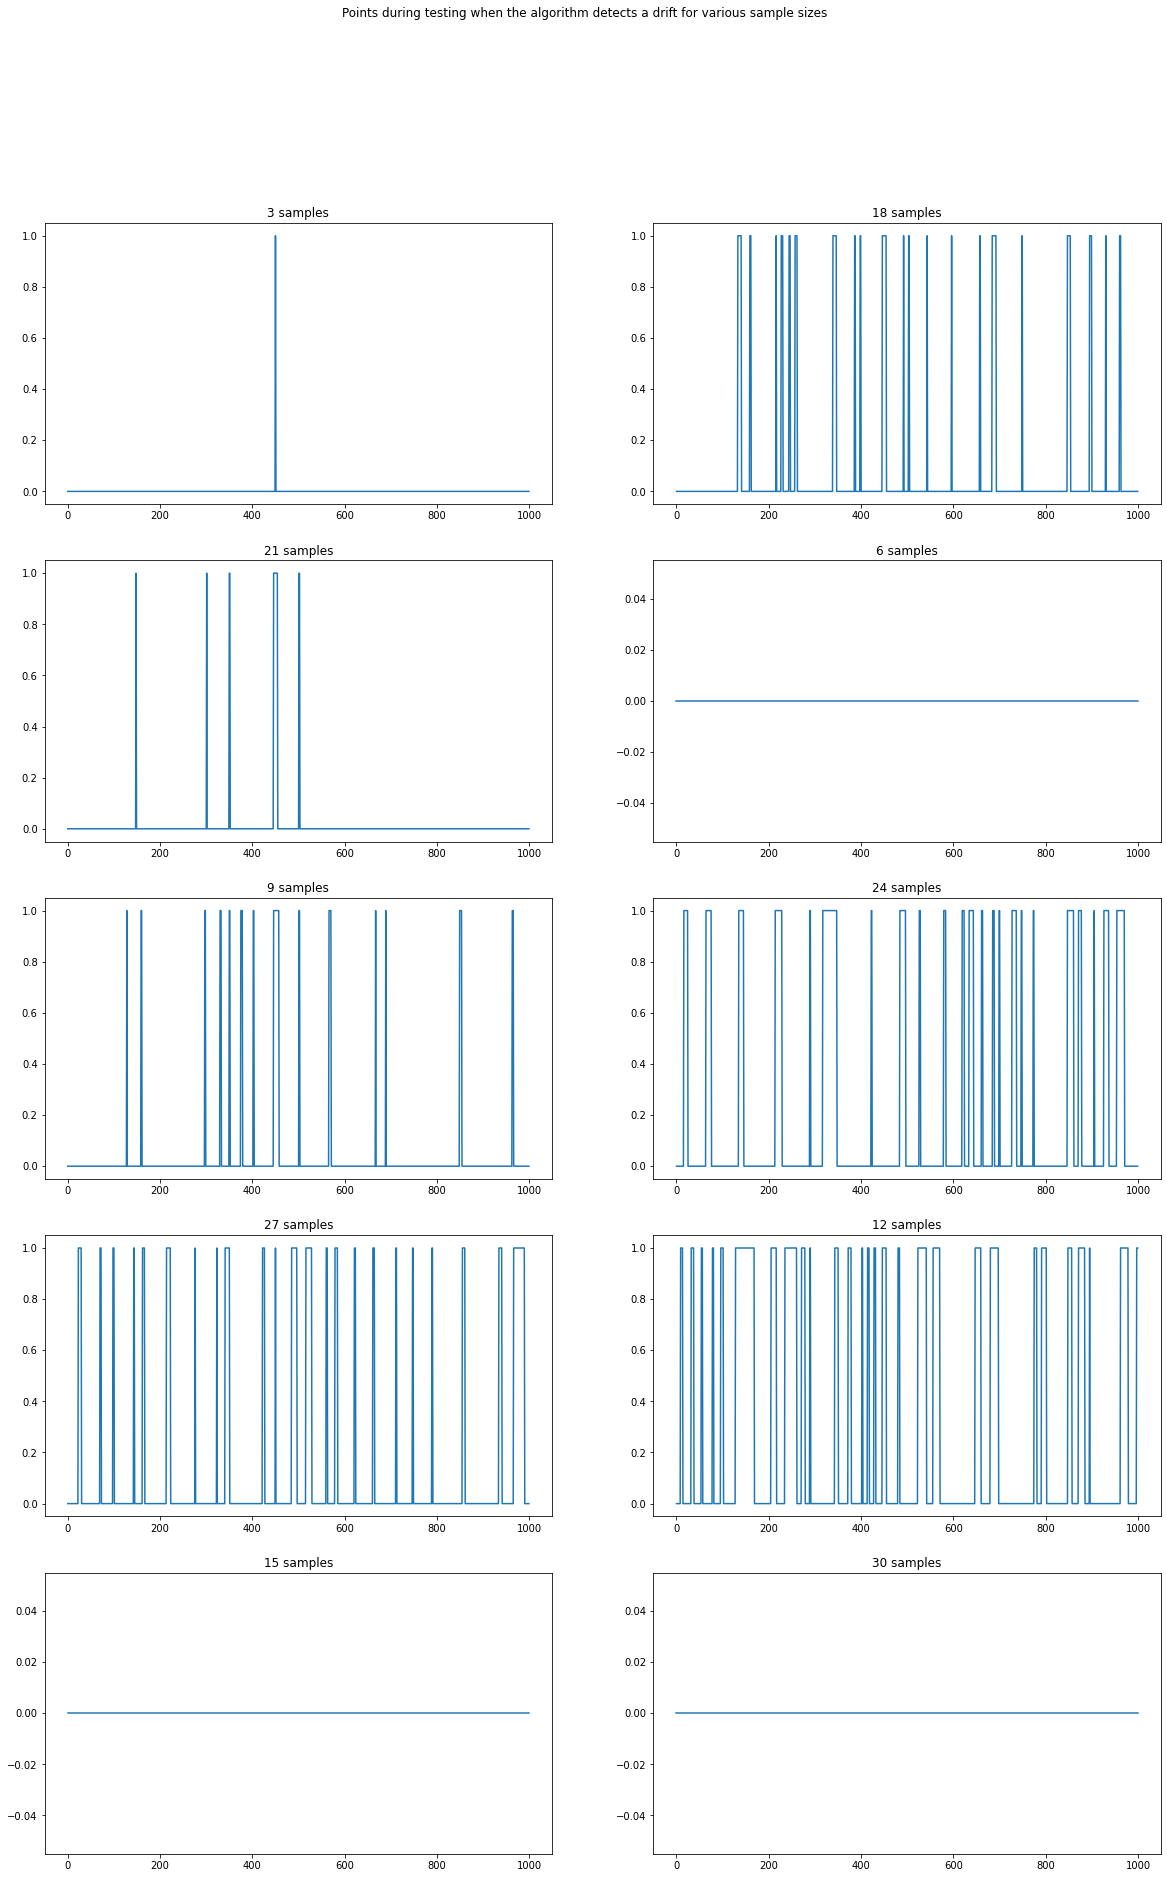

In [13]:
test_data,_ = drift_model.sample(n_test)
np.random.shuffle(test_data)
fig, ax = plt.subplots(5, 2, figsize=(20, 30))
fig.suptitle("Points during testing when the algorithm detects a drift for various sample sizes")
for iter,m in tqdm(enumerate(ms)):
    if use_mat:
        A = np.load(folder_name + 'mat/%d.npy' % m)
    else:
        A = A_[:m, :]
    mm = (m*4)//5
    flagged = []
    reconstruction = np.empty(test_data.shape)
    deviation_count = 0
    for j in range(len(test_data)):
        x = test_data[j]
        x_hat = np.zeros(x.shape)
        for i in range(x.shape[0]//d):
            y = A @ x[i*d:(i+1)*d]
            x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
            e_cv = np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d])
            if e_cv > (val_err[i] + 0.5*err_std[i]):
                deviation_count += 1
            else:
                deviation_count = 0
            if(deviation_count >= 10):
                flagged.append(1)
            else:
                flagged.append(0)
        reconstruction[j] = x_hat
    # val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
    ax[iter%5][iter%2].plot(flagged)
    ax[iter%5][iter%2].set_title('%d samples' % m)


plt.show()

Hence we observe that we almost always are able to detect a drift with the given method

In [7]:
# loading aluminium panel data
folder_name_1 = "data/aluminium_data/BASELINE_1(Healthy)/Data_with3dprinter/Data_with_dso/"
folder_name_2 = "data/aluminium_data/rivet_hole_temp/Data_with_dso/"
paths_1 = [folder_name_1 + f"Temp{x}/P14.csv" for x in range(20,70,5)]
paths_2 = [folder_name_2 + f"Temp{x}/P14.csv" for x in range(20,70,5)]
# lets only do 13 right now for different temperatures as this will show max variation in case of damages and undamaged measurements

In [8]:
from sklearn.model_selection import train_test_split

def train_GMM_to_data(db, temp,  patch_size = 100, n_components = 10, n_init = 10):
    """
    Takes the entire dataset and splits it into train and test sets. Trains on the training set 
    and returns the model and test set
    """
    d = patch_size
    entries = np.array(db["output"])
    # using overlapping patches for training
    train_data = np.empty((entries.shape[0] - d + 1, d))
    for i in range(entries.shape[0] - d + 1):
        train_data[i] = entries[i:i+d]

    train_data, test_data = train_test_split(train_data, test_size=0.6)
    print(f"train data samples = {train_data.shape[0]}")
    print(f"test data samples = {test_data.shape[0]}")
    # now make test_data non-overlapping
    test_data = np.array([test_data[i, :] for i in range(0, test_data.shape[0], d)] )
    print(f"test data samples (non-overlapping) = {test_data.shape[0]}")

    n_train = train_data.shape[0]
    folder_name = 'results/aluminium_%d/n_components=%d,n_train=%d,patch_size=%d/' % (temp, n_components, n_train, d)

    model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
    model.fit(train_data)

    if os.path.isdir(folder_name):
        for f in os.listdir(folder_name):
            if not os.path.isdir(folder_name + f):
                os.remove(folder_name + f)
    else:
        os.makedirs(folder_name)


    # finding threshold empirically using training data itself
    A_ = np.random.binomial(1, 0.5, size=(d, d))
    ms = [d*(i+1)//10 for i in range(10)]
    psnr, psnr_min, psnr_max, psnr_std = [], [], [], []
    val_err, err_std = [], []

    sample_test_data = test_data
    for m in tqdm(ms):
        if use_mat:
            A = np.load(folder_name + 'mat/%d.npy' % m)
        else:
            A = A_[:m, :]
        mm = (m*4)//5
        reconstruction = np.empty(sample_test_data.shape)
        patch_err = []
        for j in range(len(sample_test_data)):
            x = sample_test_data[j]
            x_hat = np.zeros(x.shape)
            for i in range(x.shape[0]//d):
                y = A @ x[i*d:(i+1)*d]
                x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
                patch_err.append(np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d]))
            # cs example
            reconstruction[j] = x_hat
        val, min_val, max_val, std_val = PSNR(sample_test_data, reconstruction)
        psnr.append(val)
        psnr_min.append(min_val)
        psnr_max.append(max_val)
        psnr_std.append(std_val)
        val_err.append(np.mean(patch_err))
        err_std.append(np.std(patch_err))

    print(psnr)
    print(psnr_std)
    print(val_err)
    print(err_std)
    # Save the model as a pickle in a file
    joblib.dump(model, folder_name + 'model.pkl')
    return (model, n_train, test_data, A_, np.array(val_err) + (0.5 * np.array(err_std)))

In [9]:
def get_rivet_data(db, temp, patch_size = 100):
    d = patch_size
    entries = np.array(db["output"])
    # using overlapping patches for training
    test_data = np.empty(((entries.shape[0] + d - 1)//d - 1, d))
    print(test_data.shape)
    for i in range((entries.shape[0] + d-1)//d  - 1):
        test_data[i] = entries[i*d:(i+1)*d]

    print(f"test data size = {test_data.shape[0]}")
    # now make test_data non-overlapping
    return test_data

In [10]:
def reconstruct_test_data(model, A_, test_data, temp, patch_size, n_components, n_train, thresholds, clean):
    d = patch_size
    folder_name = 'results/aluminium_%d/n_components=%d,n_train=%d,patch_size=%d/%s/' % (temp, n_components, n_train, d, clean)
    if os.path.isdir(folder_name):
        for f in os.listdir(folder_name):
            if not os.path.isdir(folder_name + f):
                os.remove(folder_name + f)
    else:
        os.makedirs(folder_name)

    ms = [d*(i+1)//10 for i in range(10)]
    psnr, psnr_min, psnr_max, psnr_std = [], [], [], []
    val_err, err_std = [], []

    fig1, ax1 = plt.subplots(5, 2, figsize=(20, 30))
    if clean == "clean":
        fig1.suptitle("Number of consecutive samples that deviate")
    else:
        fig1.suptitle("Points during testing when the algorithm detects a drift for various sample sizes")

    for f,m in tqdm(enumerate(ms)):
        if use_mat:
            A = np.load(folder_name + 'mat/%d.npy' % m)
        else:
            A = A_[:m, :]
        mm = (m*4)//5
        reconstruction = np.empty(test_data.shape)
        patch_err = []
        cnt1 = cnt
        deviations = 0
        flagged = []
        deviation_count = []
        for j in range(len(test_data)):
            x = test_data[j]
            x_hat = np.zeros(x.shape)
            for i in range(x.shape[0]//d):
                y = A @ x[i*d:(i+1)*d]
                x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
                patch_err.append(np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d]))
                if(patch_err[-1] > thresholds[f]):
                    deviations += 1
                else:
                    deviations = 0
                if(deviations >= 5):
                    flagged.append(1)
                else:
                    flagged.append(0)
                deviation_count.append(deviations)
            # cs example
            if cnt1 > 0:
                plt.figure()
                plt.plot(x, label='Original', color = "C0")
                plt.plot(x_hat, label='Reconstructed', color = "C1")
                plt.legend()
                plt.savefig(folder_name + 'cs_%d_%d.png' % (cnt1, mm))
                plt.close()
                cnt1 -= 1
            reconstruction[j] = x_hat
        val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
        psnr.append(val)
        psnr_min.append(min_val)
        psnr_max.append(max_val)
        psnr_std.append(std_val)
        val_err.append(np.mean(patch_err))
        err_std.append(np.std(patch_err))
        if clean == "clean":
            ax1[f%5][f%2].plot(deviation_count)
        else:
            ax1[f%5][f%2].plot(flagged)
        ax1[f%5][f%2].set_title('%d samples' % m)

    plt.show()
    print(psnr)
    print(psnr_std)
    print(val_err)
    print(err_std)
    plot_data([x//5*4 for x in ms], psnr, path=folder_name + 'psnr.png')
    plot_data([x//5*4 for x in ms], val_err, path=folder_name + 'val_err.png', ylabel='Validation error (1e-2)')

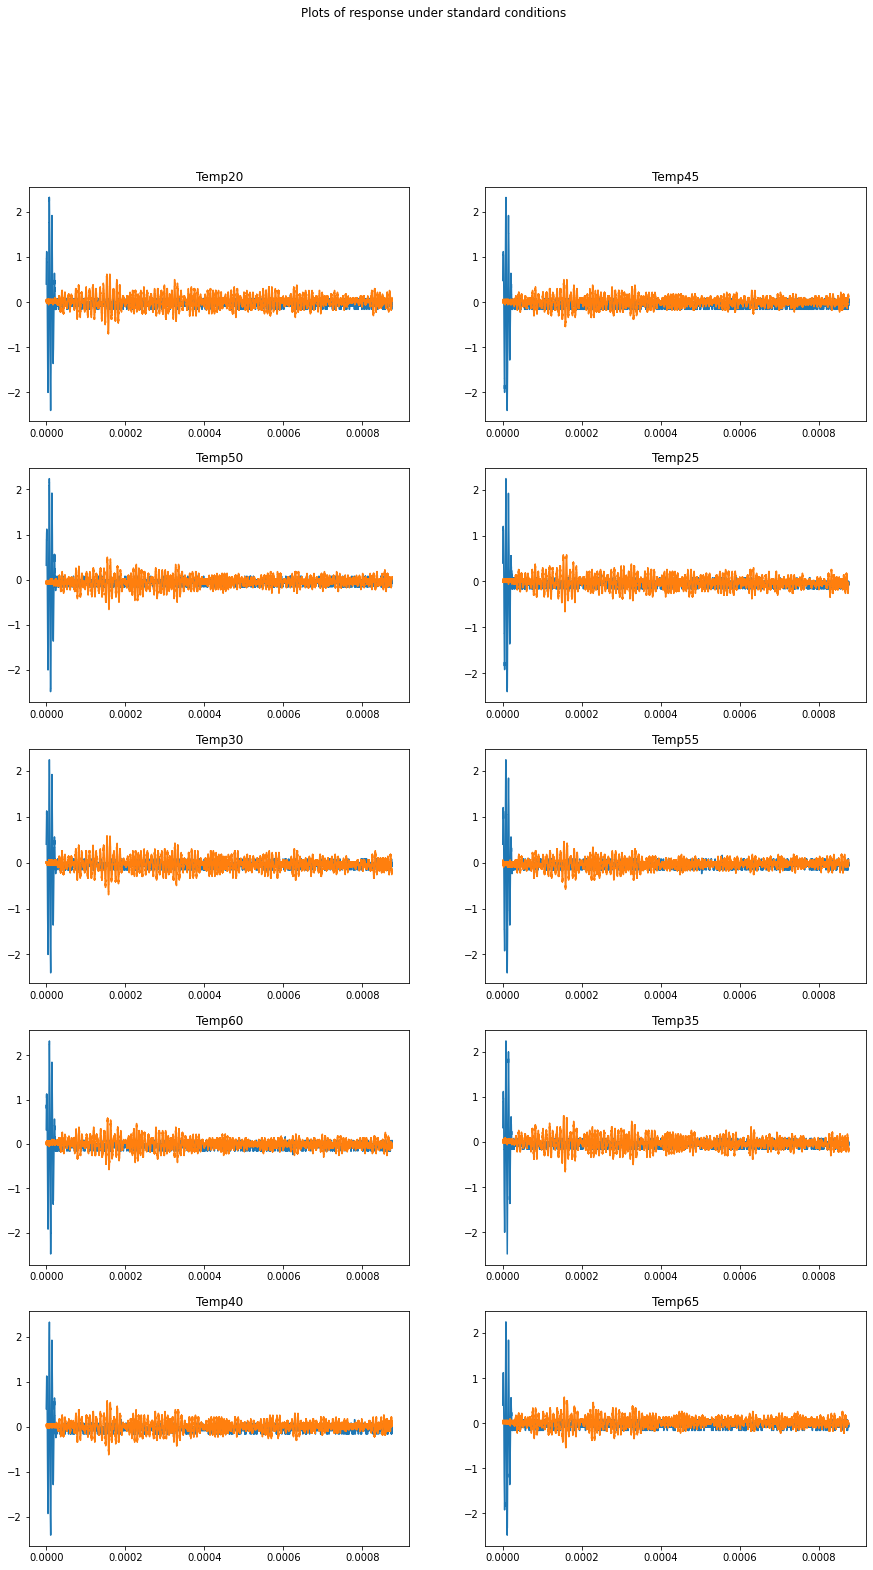

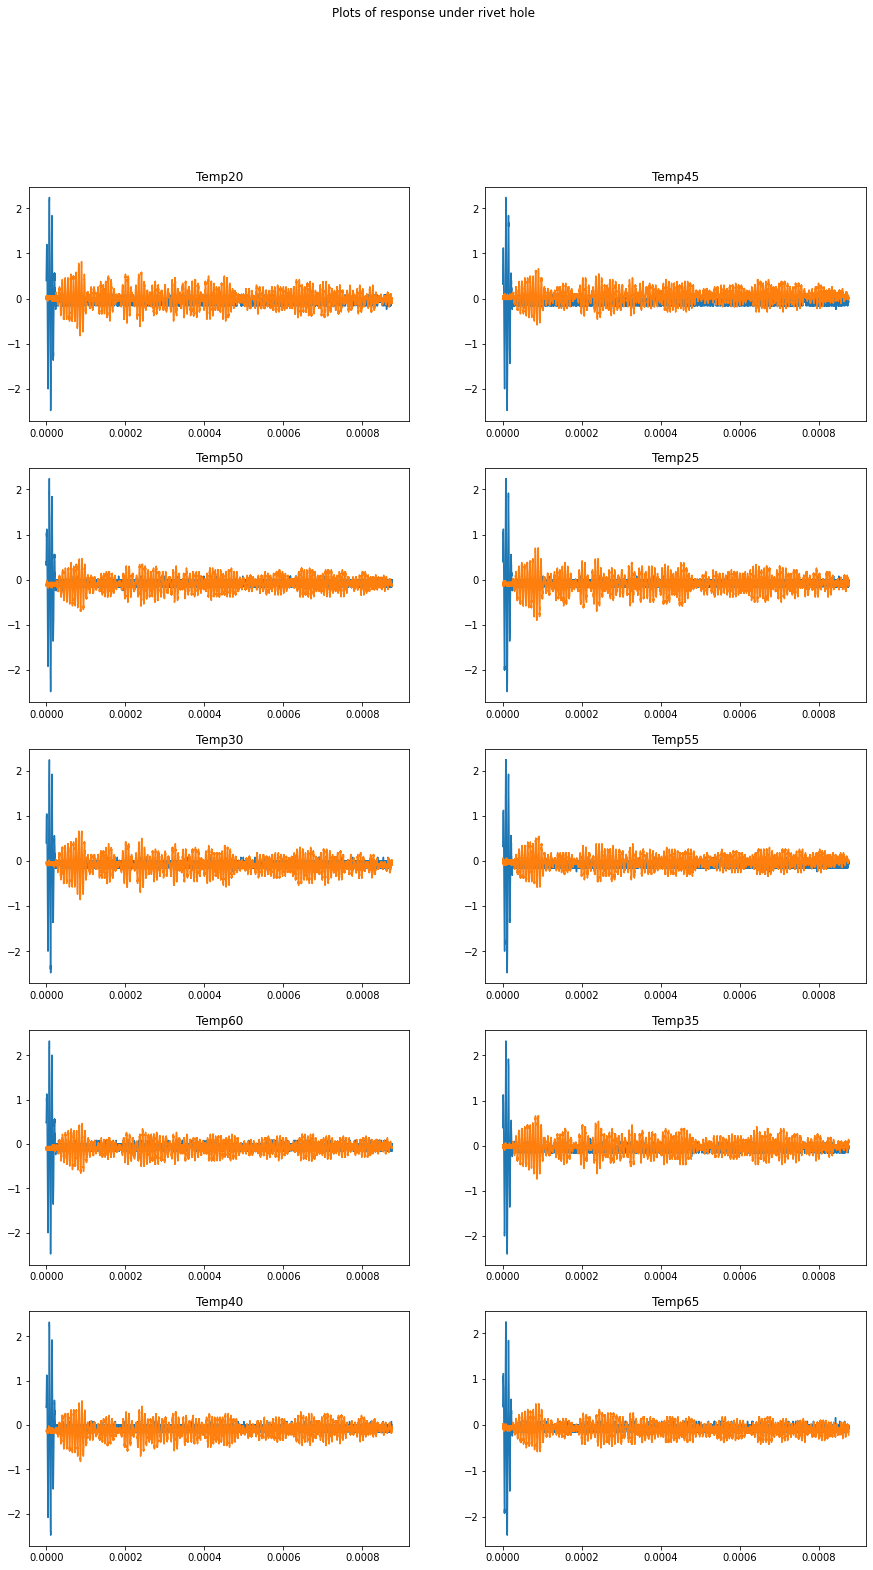

train data samples = 6959
test data samples = 10440
test data samples (non-overlapping) = 105
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 3
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 4
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True


100%|██████████| 10/10 [00:41<00:00,  4.18s/it]


[31.067543482526663, 33.5095737348249, 34.51069529086427, 35.13871180304034, 35.78483721251748, 36.48598640462774, 37.132966542879274, 38.08591690911762, 39.157442158701656, 40.5779331887821]
[2.2486652887832834, 1.022425681737499, 0.8527853638272047, 0.8869554901591181, 0.8790422758561953, 0.9421092595921529, 0.9535977138442013, 1.134598285940727, 1.1689105576697625, 1.4205651604515992]
[0.2125088531484773, 0.2662774032977073, 0.294722719978245, 0.33375911004207914, 0.3301975585469185, 0.349210332254223, 0.34320692685411497, 0.3295461035256352, 0.310834220396309, 0.27896675978653207]
[0.12089321926389061, 0.10616260831269994, 0.09222723270800913, 0.0861087199162118, 0.07210636333001018, 0.09473092765375773, 0.07494121008395721, 0.07615052807232724, 0.06952568016716425, 0.06046767425585975]


10it [02:00, 12.02s/it]


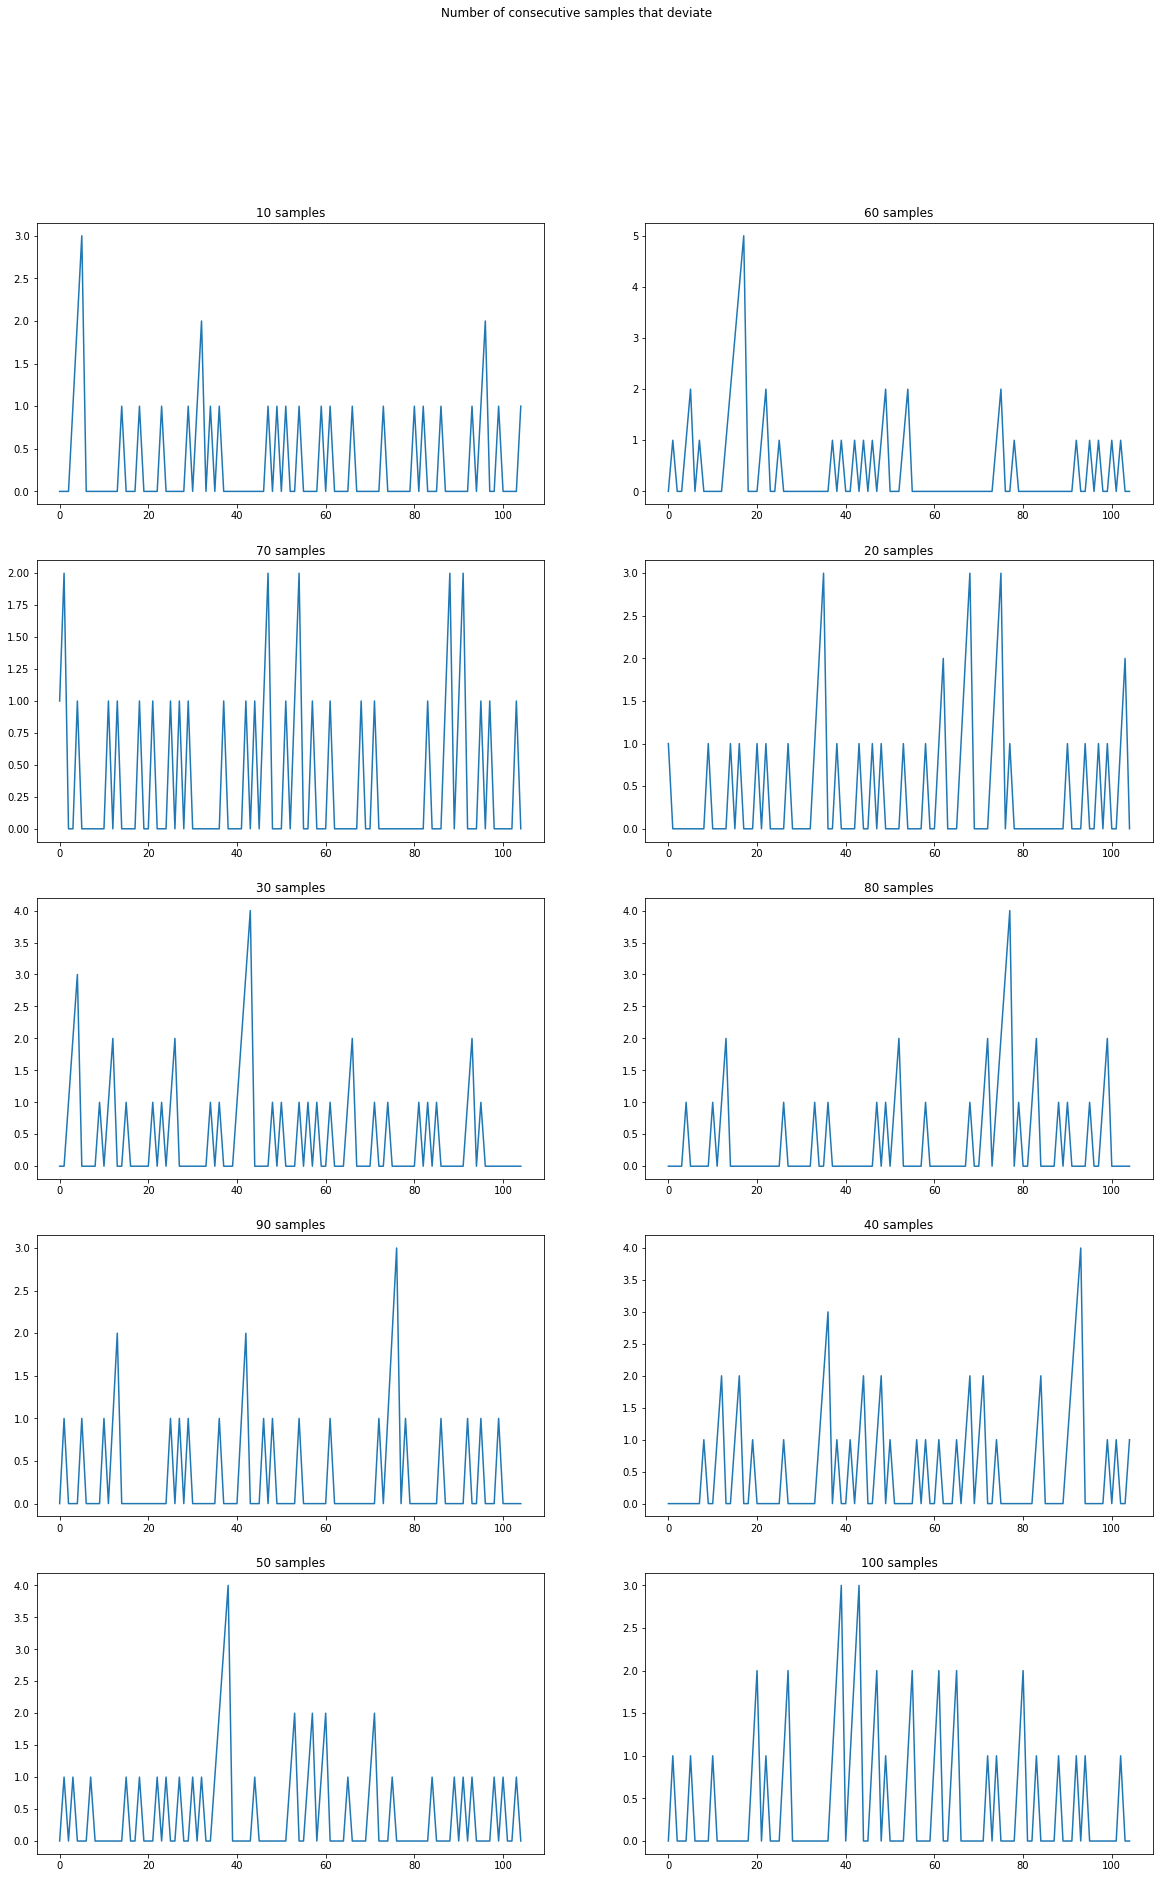

[31.067543482526663, 33.5095737348249, 34.51069529086427, 35.13871180304034, 35.78483721251748, 36.48598640462774, 37.132966542879274, 38.08591690911762, 39.157442158701656, 40.5779331887821]
[2.2486652887832834, 1.022425681737499, 0.8527853638272047, 0.8869554901591181, 0.8790422758561953, 0.9421092595921529, 0.9535977138442013, 1.134598285940727, 1.1689105576697625, 1.4205651604515992]
[0.2125088531484773, 0.2662774032977073, 0.294722719978245, 0.33375911004207914, 0.3301975585469185, 0.349210332254223, 0.34320692685411497, 0.3295461035256352, 0.310834220396309, 0.27896675978653207]
[0.12089321926389061, 0.10616260831269994, 0.09222723270800913, 0.0861087199162118, 0.07210636333001018, 0.09473092765375773, 0.07494121008395721, 0.07615052807232724, 0.06952568016716425, 0.06046767425585975]
(174, 100)
test data size = 174


10it [01:41, 10.16s/it]


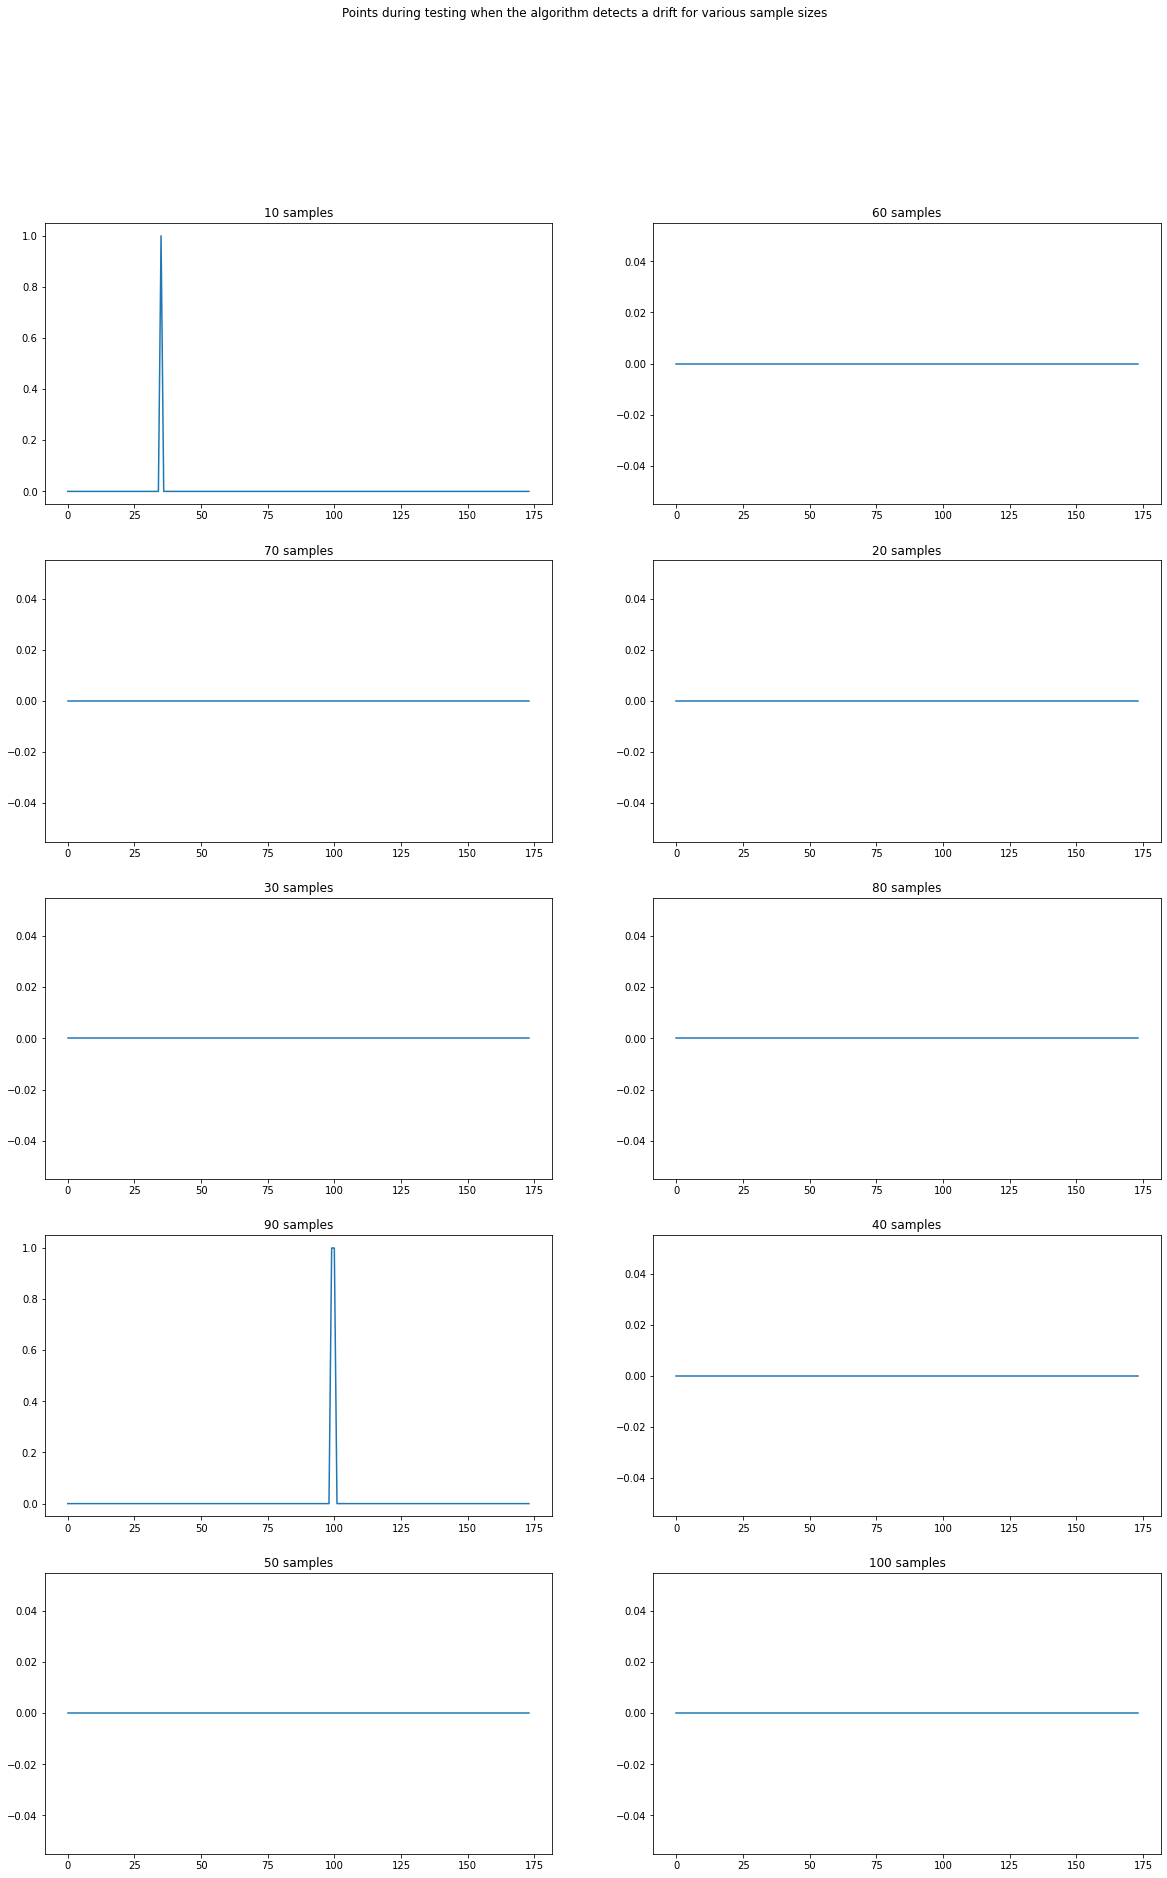

[32.618978215389326, 35.72809009146401, 36.60205653671262, 37.372883931062, 38.033103127688435, 38.69375094658907, 39.3756845437354, 40.29181675217971, 41.31219010276434, 42.76784707839422]
[2.258223633127147, 1.1818974736428394, 0.9664733027444937, 0.9961047441511466, 1.0044389788437014, 1.061331020143509, 1.1222670260558782, 1.1795452843406, 1.2673021604549495, 1.4382750383863063]
[0.22313746817695065, 0.28249918742817415, 0.3086723231068916, 0.3236084079269324, 0.32718781624566184, 0.3466310729294982, 0.3413669023548429, 0.32762808215319367, 0.3146120043583916, 0.28716994224470643]
[0.11799362456277715, 0.12193451500602852, 0.09282208061572986, 0.08425230558340753, 0.07478004689746762, 0.08292370474881564, 0.0744006695281399, 0.07164266238390432, 0.06607554198824783, 0.06145420216345679]
train data samples = 6959
test data samples = 10440
test data samples (non-overlapping) = 105
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: T

100%|██████████| 10/10 [00:51<00:00,  5.11s/it]


[28.805406589218638, 30.36509064327044, 31.677435872908323, 32.49383152155466, 33.21821325886482, 33.958951427032304, 34.65371988745696, 35.622440946855846, 36.69922420247421, 38.19213424069667]
[1.7250682713875347, 1.25946036357871, 0.8183677832354018, 0.7699602668850317, 0.8614420350601326, 0.9124402028579139, 1.0074422728098957, 1.1830309814467443, 1.264112764048154, 1.3726239799919604]
[0.19436787293789912, 0.2970727575534408, 0.3032618642745435, 0.35266374087552377, 0.3410735615926021, 0.33695853877681264, 0.34815107291401215, 0.325216110967363, 0.2996105325275234, 0.27093963898350265]
[0.10592091237052069, 0.11877637447136614, 0.08861470099812391, 0.08734113493267597, 0.08106606022949751, 0.06644730575260682, 0.07637165444841142, 0.07342985058339321, 0.05974731629676883, 0.06073285705051111]


10it [00:49,  4.92s/it]


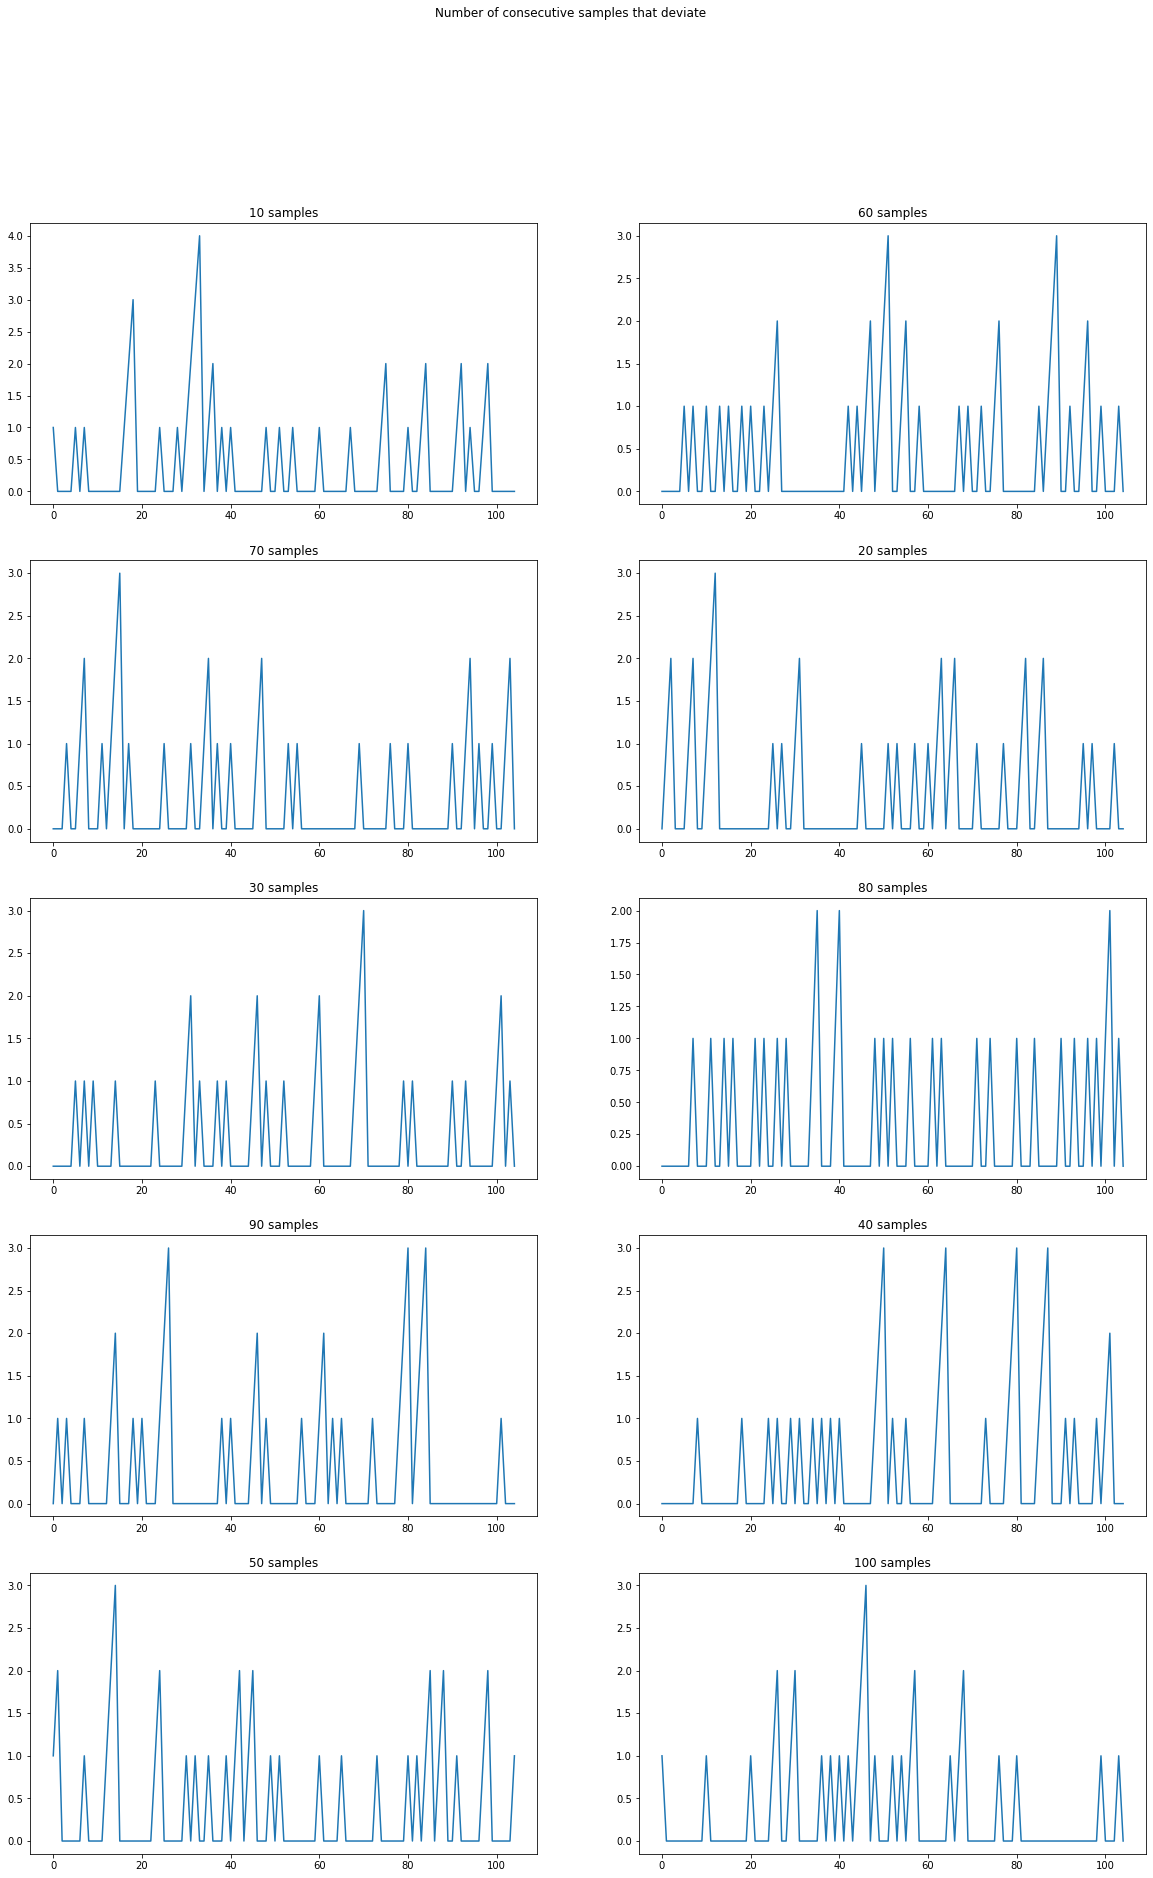

[28.805406589218638, 30.36509064327044, 31.677435872908323, 32.49383152155466, 33.21821325886482, 33.958951427032304, 34.65371988745696, 35.622440946855846, 36.69922420247421, 38.19213424069667]
[1.7250682713875347, 1.25946036357871, 0.8183677832354018, 0.7699602668850317, 0.8614420350601326, 0.9124402028579139, 1.0074422728098957, 1.1830309814467443, 1.264112764048154, 1.3726239799919604]
[0.19436787293789912, 0.2970727575534408, 0.3032618642745435, 0.35266374087552377, 0.3410735615926021, 0.33695853877681264, 0.34815107291401215, 0.325216110967363, 0.2996105325275234, 0.27093963898350265]
[0.10592091237052069, 0.11877637447136614, 0.08861470099812391, 0.08734113493267597, 0.08106606022949751, 0.06644730575260682, 0.07637165444841142, 0.07342985058339321, 0.05974731629676883, 0.06073285705051111]
(174, 100)
test data size = 174


10it [01:21,  8.12s/it]


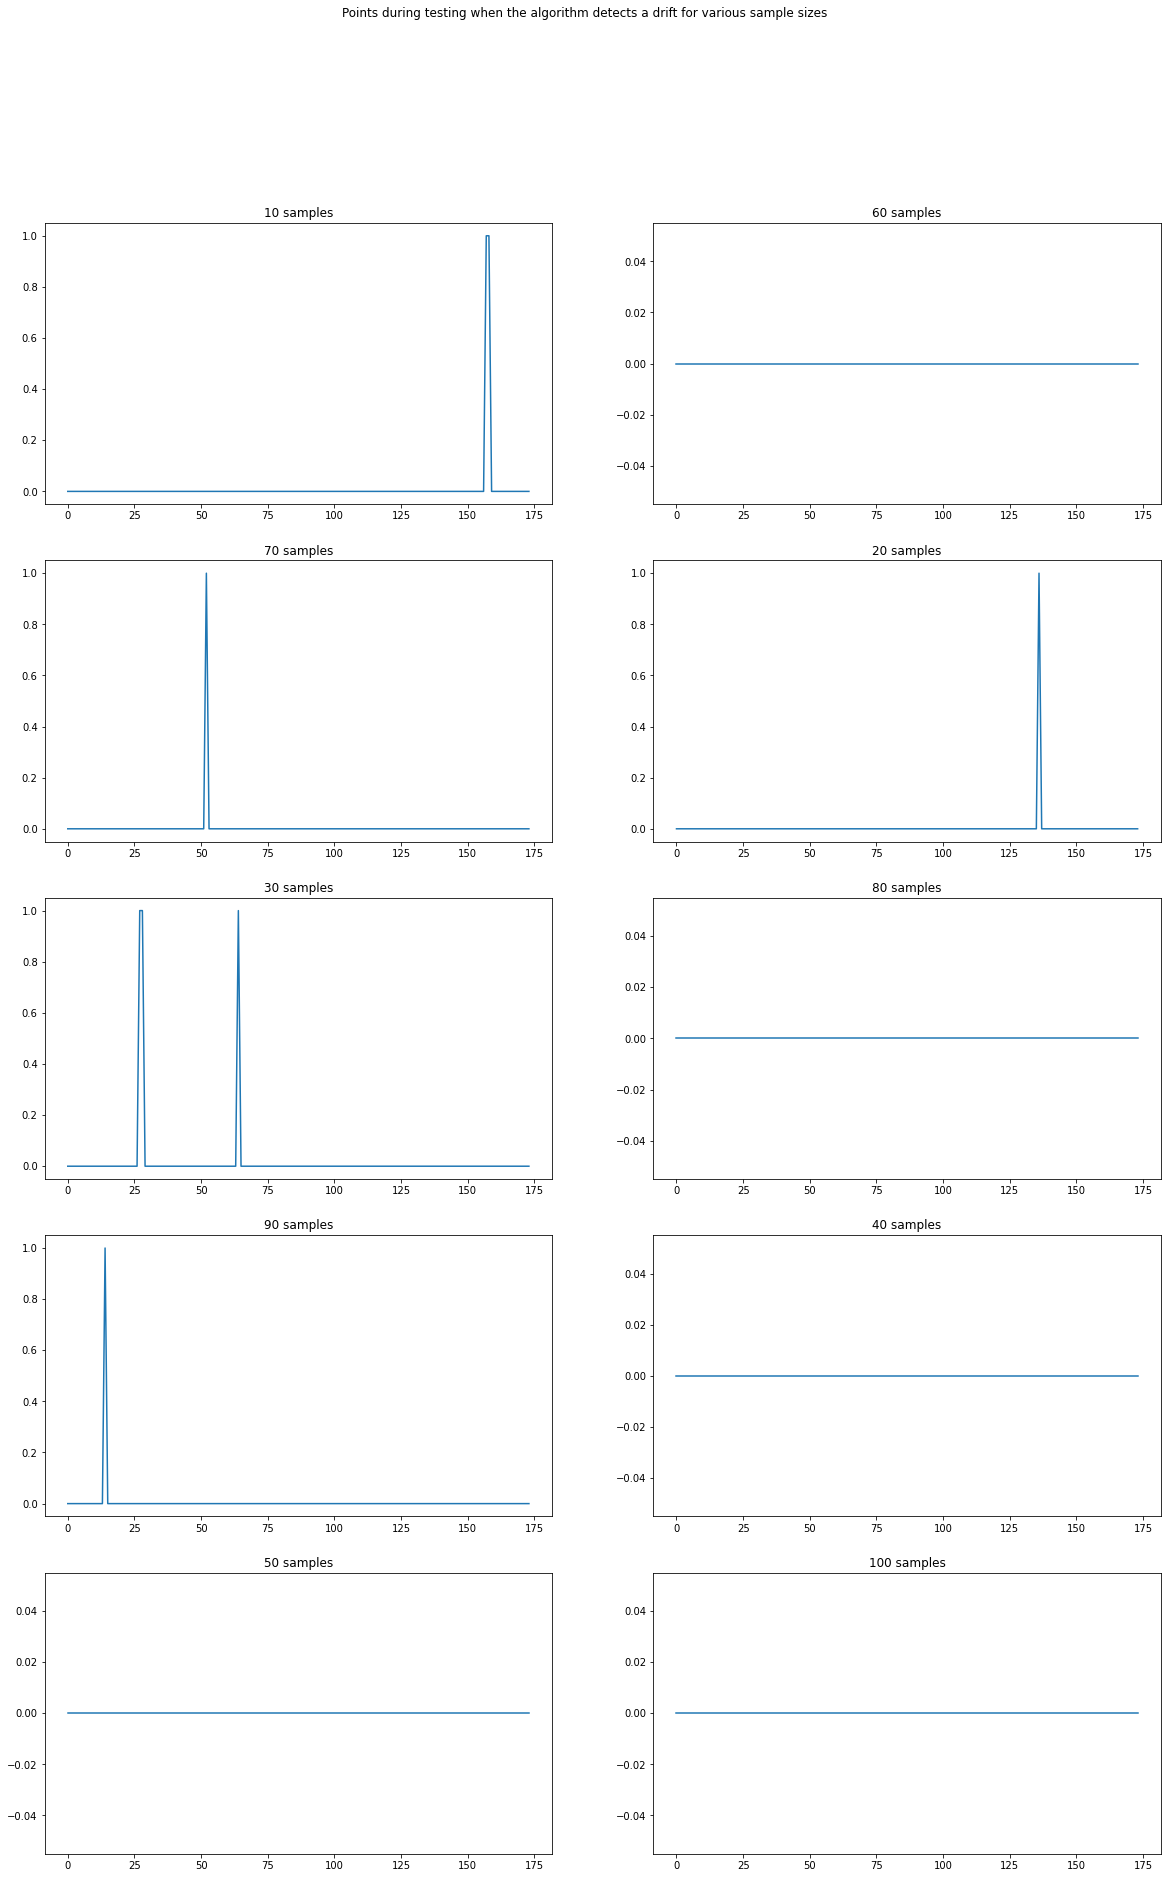

[31.474776755828945, 33.858772544758395, 35.475981029641424, 36.3241115169873, 36.90624036006634, 37.621456775899915, 38.37168200178361, 39.284760563535805, 40.34473718925961, 41.76754560923315]
[2.3837511385770807, 1.493830809240393, 0.9537153405842438, 0.9035433356072073, 0.8988752095781262, 0.9089911312527529, 0.98409685593767, 1.0958063017555284, 1.3855107884946067, 1.6031136972294224]
[0.2034913436034154, 0.3376439642461838, 0.33605217319941777, 0.3291056308184667, 0.3386313859510202, 0.34650314430178153, 0.3569495193430361, 0.3378473746084565, 0.3128337111957262, 0.2833809194080788]
[0.11586102577133693, 0.12579031124681248, 0.10252267069198832, 0.08684415465889414, 0.08306282389818401, 0.08567878571863637, 0.08872166810428807, 0.06975396506821008, 0.06866683851354895, 0.06622495622898729]
train data samples = 6959
test data samples = 10440
test data samples (non-overlapping) = 105
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initial

100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


[30.480564322101287, 32.09128331733568, 33.417124694823, 34.28568441767053, 34.99759559220099, 35.59074456611305, 36.28949691550565, 37.222010535316585, 38.31945841298426, 39.88612999143722]
[2.061489933933565, 1.588200175677122, 0.952091228048512, 0.8584264901839797, 0.8227918522515105, 0.8398577257193499, 0.8826408891775356, 1.0471409791414976, 1.2864906116704247, 1.4920835628197249]
[0.19341668503448475, 0.27377666717815313, 0.3217411047948241, 0.3334421957901039, 0.31384997675538856, 0.34356302755432594, 0.35829262602726514, 0.3296820090714757, 0.3164778680650907, 0.2838454025372848]
[0.1038973480499396, 0.10137533021002276, 0.10131241001016085, 0.09019459770855104, 0.07832384498361851, 0.08113061352180258, 0.07807572229820707, 0.08618431525448925, 0.0780681230860419, 0.06256286753537124]


10it [01:06,  6.62s/it]


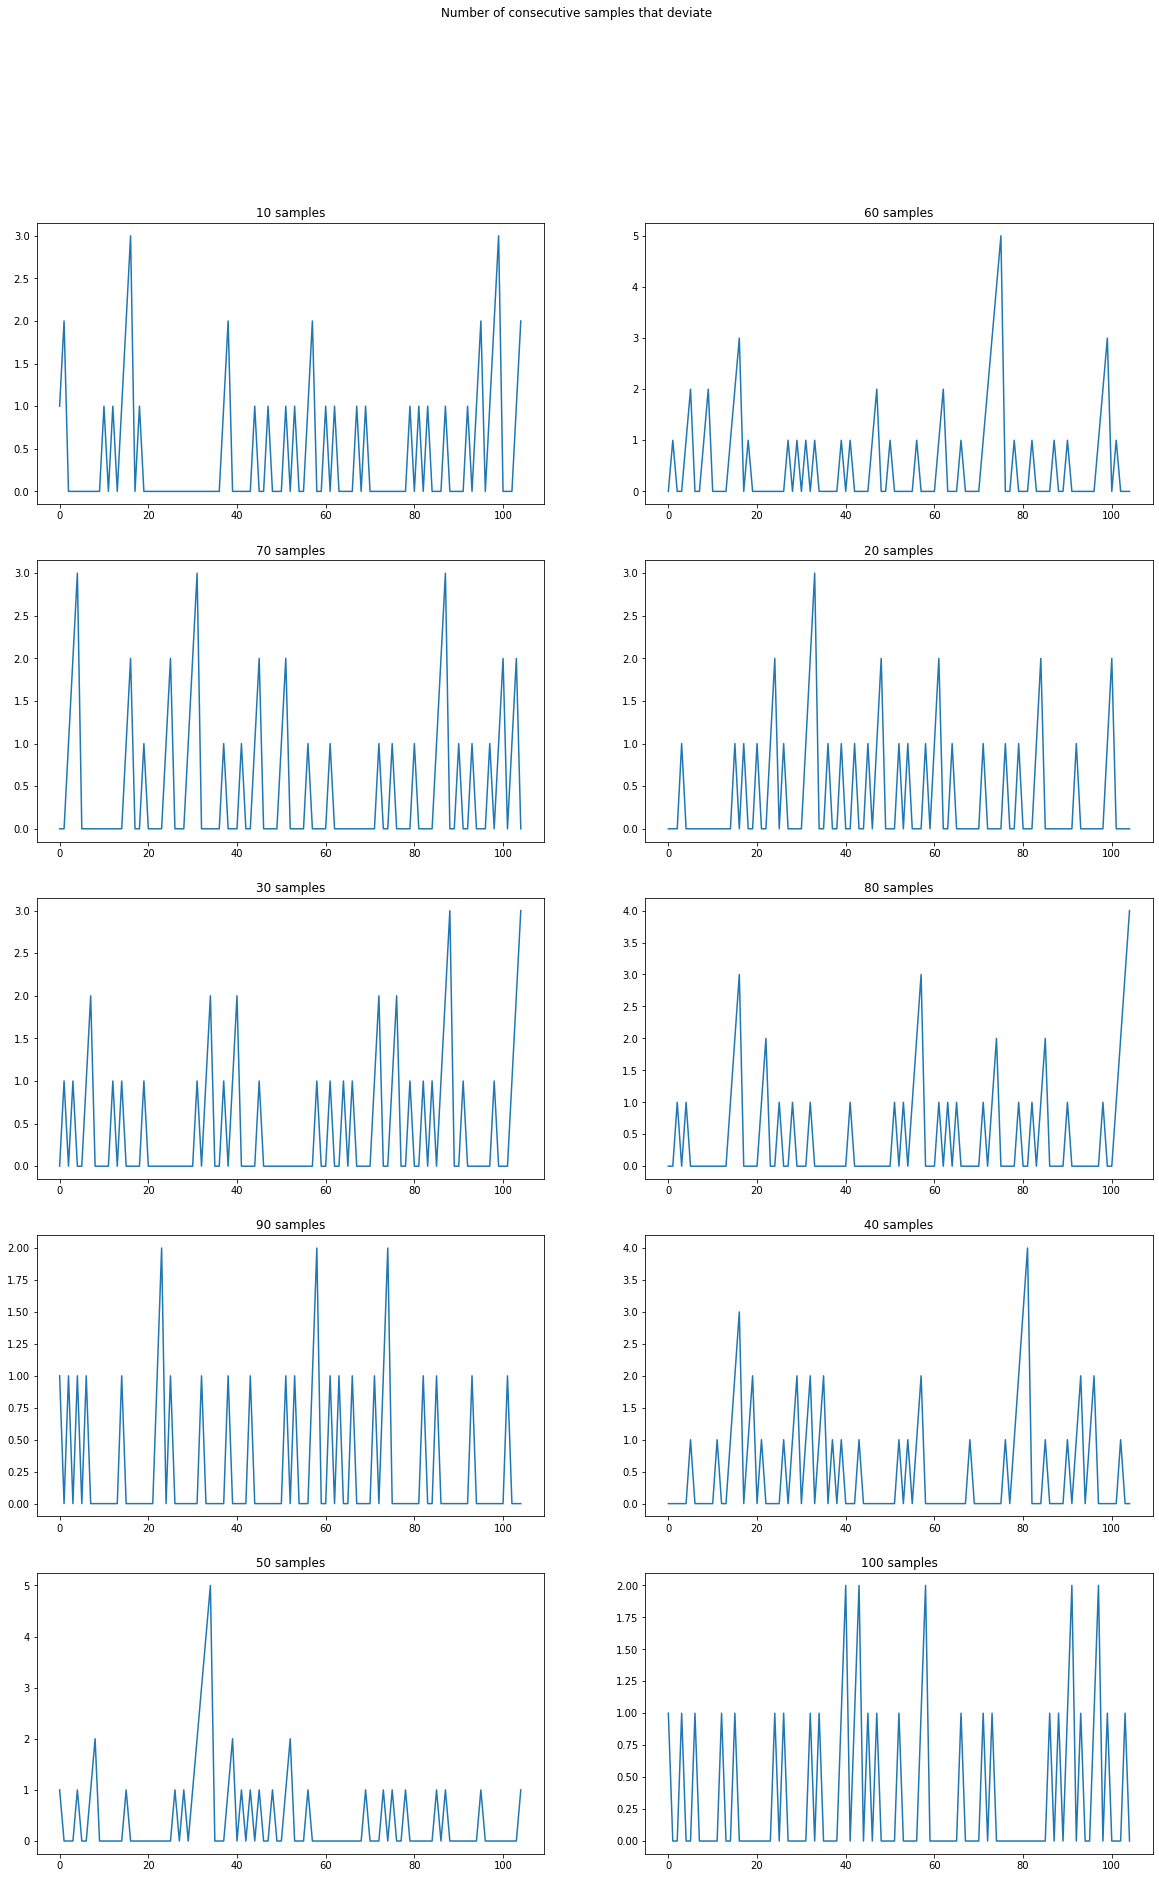

[30.480564322101287, 32.09128331733568, 33.417124694823, 34.28568441767053, 34.99759559220099, 35.59074456611305, 36.28949691550565, 37.222010535316585, 38.31945841298426, 39.88612999143722]
[2.061489933933565, 1.588200175677122, 0.952091228048512, 0.8584264901839797, 0.8227918522515105, 0.8398577257193499, 0.8826408891775356, 1.0471409791414976, 1.2864906116704247, 1.4920835628197249]
[0.19341668503448475, 0.27377666717815313, 0.3217411047948241, 0.3334421957901039, 0.31384997675538856, 0.34356302755432594, 0.35829262602726514, 0.3296820090714757, 0.3164778680650907, 0.2838454025372848]
[0.1038973480499396, 0.10137533021002276, 0.10131241001016085, 0.09019459770855104, 0.07832384498361851, 0.08113061352180258, 0.07807572229820707, 0.08618431525448925, 0.0780681230860419, 0.06256286753537124]
(174, 100)
test data size = 174


10it [01:36,  9.68s/it]


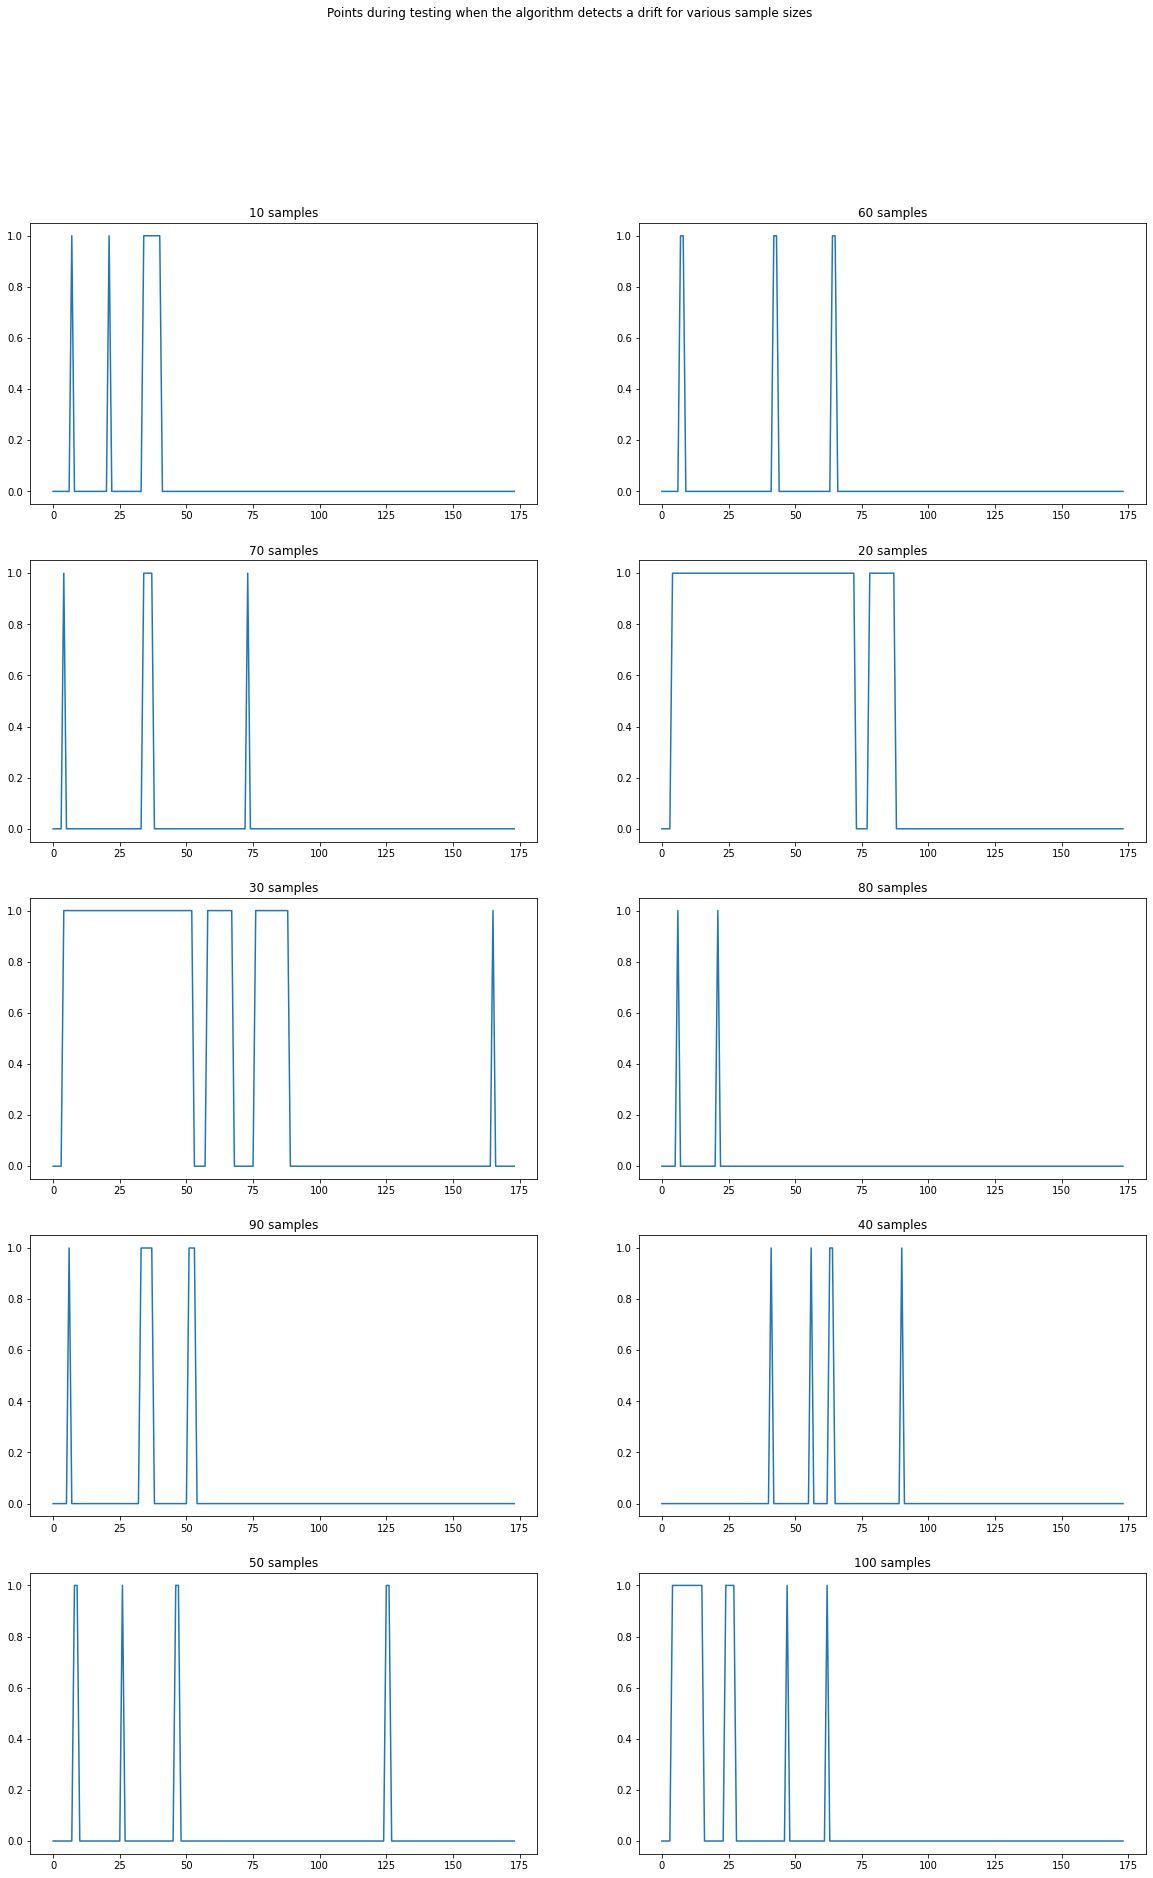

[24.880467485501576, 27.438736102326278, 32.26940626262204, 34.84585280122296, 35.74526438342852, 36.38591427220208, 37.1345830576591, 38.02065357237612, 39.099314855483904, 40.496032592012305]
[4.533632556963021, 4.362288929302213, 2.4783827110038987, 1.4479460174004777, 1.2978001323620705, 1.2330780447458283, 1.2525903226375052, 1.3085350586259963, 1.5351801543428787, 1.7889556271248064]
[0.2677455194397976, 0.4825558994831052, 0.5868237880431411, 0.38588932269684834, 0.3549721728341757, 0.37992295963240613, 0.391293035919194, 0.3588620080537071, 0.35698340418818164, 0.3259535976129365]
[0.12884199767641127, 0.22241660954499987, 0.2587204711114618, 0.11137155049608202, 0.09583506673483885, 0.08508771702319337, 0.08095685308883699, 0.07795143279468932, 0.08440997988512645, 0.08245721965987891]
train data samples = 6959
test data samples = 10440
test data samples (non-overlapping) = 105
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initial

100%|██████████| 10/10 [00:49<00:00,  4.99s/it]


[28.127602979566923, 30.835071944191753, 31.79506558314762, 32.44149537721562, 33.01695617423478, 33.65351270989872, 34.40050917895367, 35.24630735001185, 36.32564308904263, 37.9303209448469]
[2.033732892574952, 1.0037192565319286, 0.8762102953787912, 0.8284806121626486, 0.8790755490680445, 1.0189832183306322, 1.0273178861653232, 1.1181705167632836, 1.1722327896664924, 1.517322026202747]
[0.2910068454468676, 0.25959529728776515, 0.29285015036051654, 0.3092516504737241, 0.33788427232616247, 0.3390704240581216, 0.3350172860965716, 0.3414231286503772, 0.32728914483834776, 0.2681443260239927]
[0.18805352905409203, 0.09767685354235413, 0.08731209956788404, 0.08769543106756132, 0.07807339974086216, 0.07944807513235005, 0.07559794390810942, 0.08269239035713605, 0.07055410030413402, 0.06045821851049708]


10it [00:45,  4.51s/it]


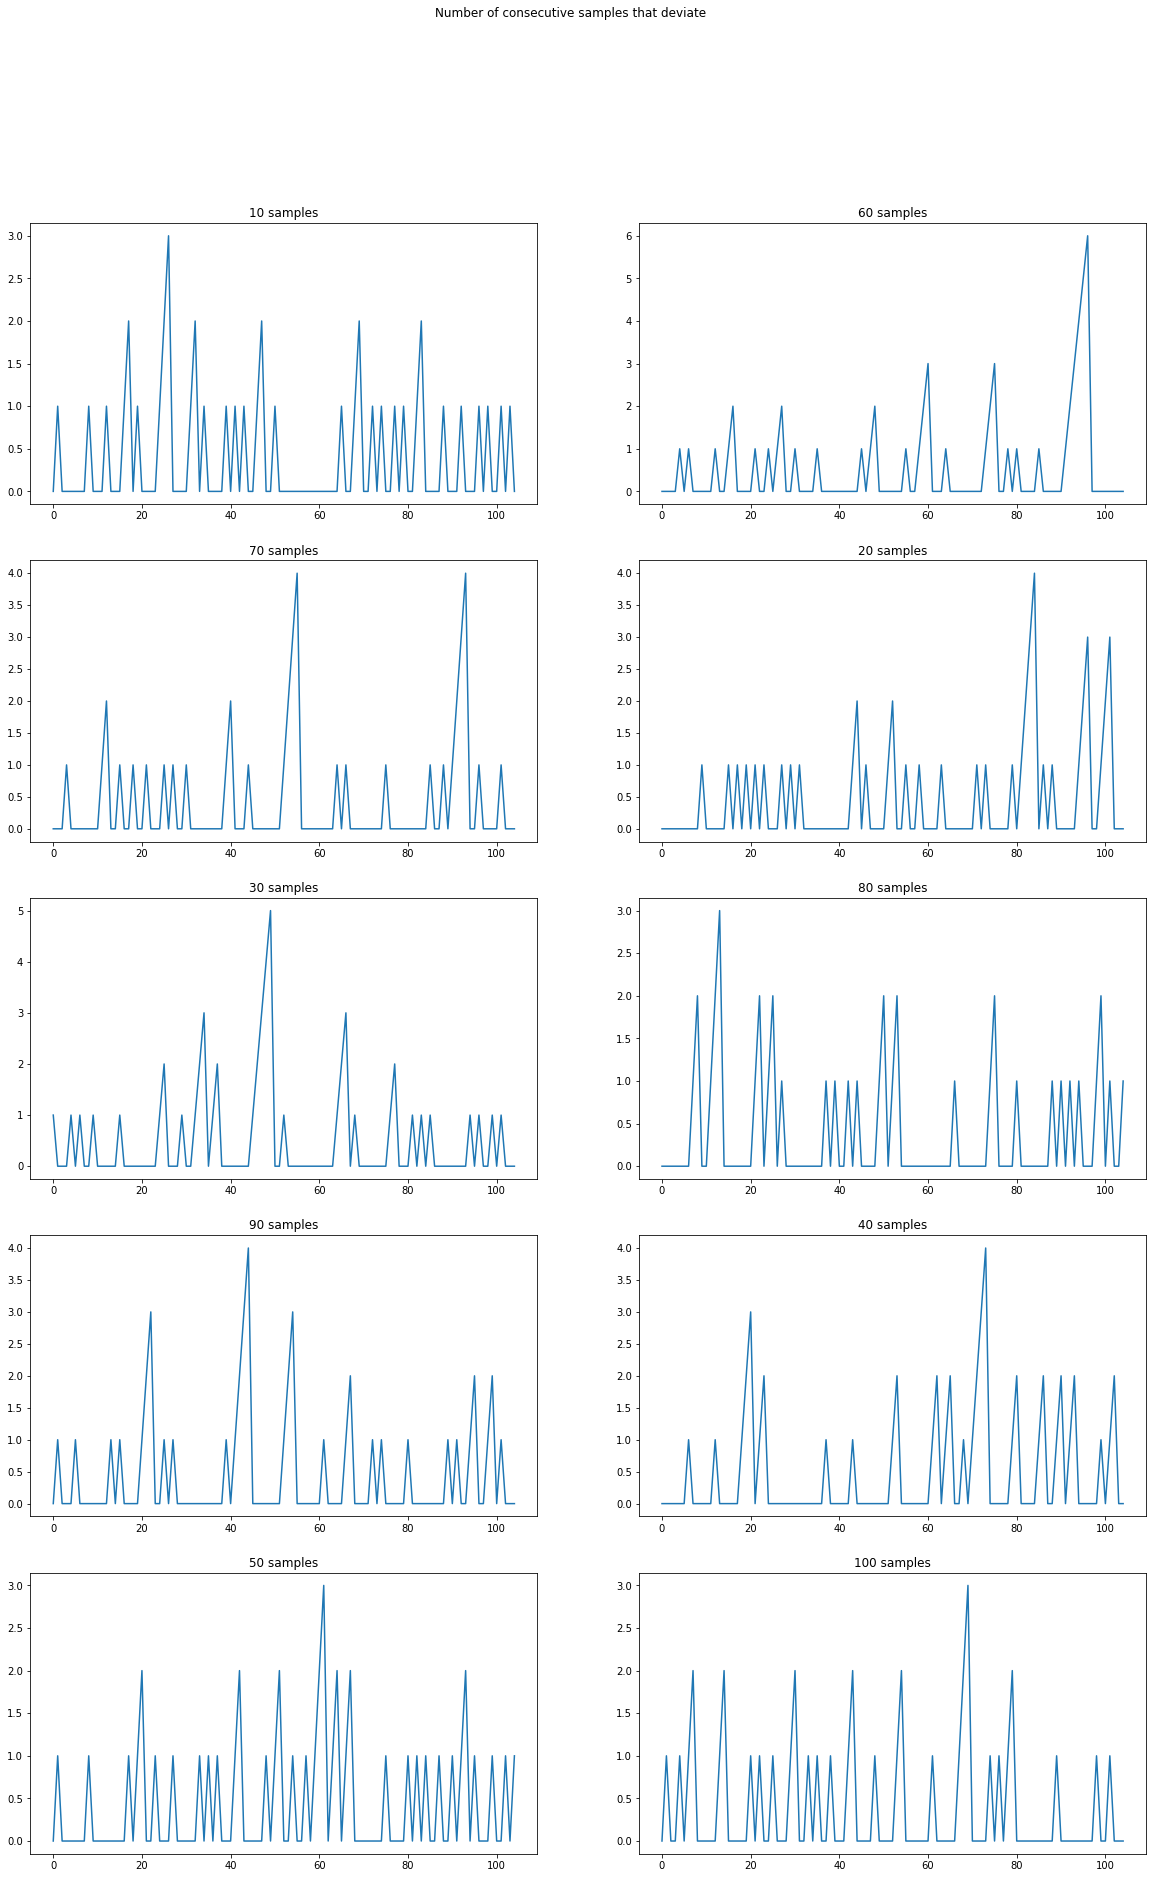

[28.127602979566923, 30.835071944191753, 31.79506558314762, 32.44149537721562, 33.01695617423478, 33.65351270989872, 34.40050917895367, 35.24630735001185, 36.32564308904263, 37.9303209448469]
[2.033732892574952, 1.0037192565319286, 0.8762102953787912, 0.8284806121626486, 0.8790755490680445, 1.0189832183306322, 1.0273178861653232, 1.1181705167632836, 1.1722327896664924, 1.517322026202747]
[0.2910068454468676, 0.25959529728776515, 0.29285015036051654, 0.3092516504737241, 0.33788427232616247, 0.3390704240581216, 0.3350172860965716, 0.3414231286503772, 0.32728914483834776, 0.2681443260239927]
[0.18805352905409203, 0.09767685354235413, 0.08731209956788404, 0.08769543106756132, 0.07807339974086216, 0.07944807513235005, 0.07559794390810942, 0.08269239035713605, 0.07055410030413402, 0.06045821851049708]
(174, 100)
test data size = 174


10it [01:06,  6.64s/it]


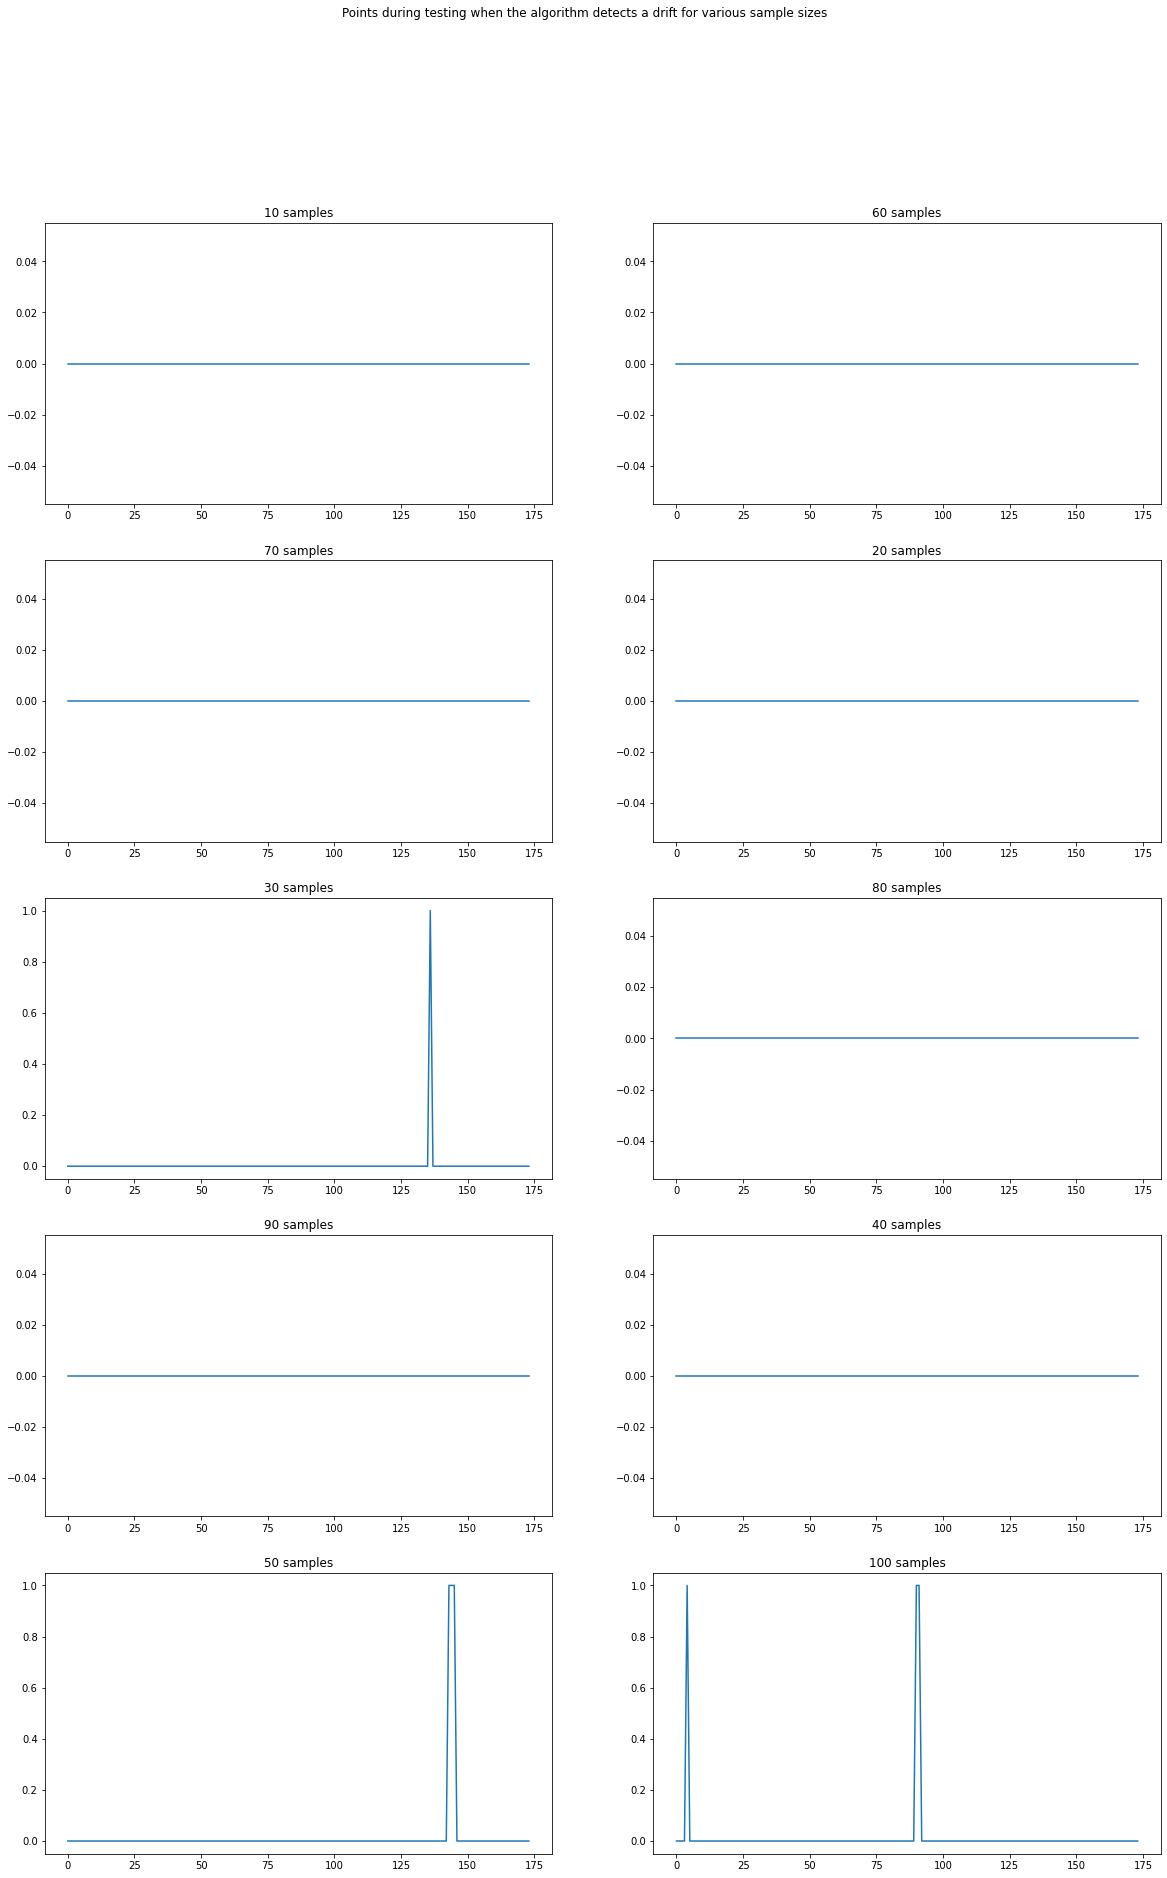

[30.190465527754764, 32.98345240984284, 34.02706694009893, 34.58720547929157, 35.13533995722118, 35.81387860149579, 36.632414805880465, 37.47136967940989, 38.54768372641676, 39.98443354162342]
[2.188384134832698, 1.2325000969569415, 0.924882144900524, 0.868847160177286, 0.917754604702256, 0.9936891313327967, 1.1495531525326301, 1.20574347426872, 1.289753294841081, 1.53320365175965]
[0.3129251569778133, 0.265810820984921, 0.2871878776672387, 0.31595709284824125, 0.34777492782912883, 0.34324229584245003, 0.3369369376353072, 0.33686059390288997, 0.31995619443621787, 0.272470242698891]
[0.16367885241120367, 0.10738897981188485, 0.09274064109605547, 0.08550799990674948, 0.0834345855633662, 0.0788998434296972, 0.07580055013834452, 0.08713296431799462, 0.07036653309898214, 0.06910085541955245]
train data samples = 6959
test data samples = 10440
test data samples (non-overlapping) = 105
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True


100%|██████████| 10/10 [00:39<00:00,  3.93s/it]


[30.506057338940103, 31.90991325479787, 32.60490018379345, 33.263940630762356, 33.81455746922563, 34.4032892913285, 35.121966339056016, 36.07853585585723, 37.18000576901678, 38.661985339432086]
[1.3576483354915865, 0.900092134480331, 0.7974001036281216, 0.7424497154347209, 0.745236556368103, 0.8054960192346924, 0.8736923131667194, 1.0087808658388728, 1.1040179513053954, 1.4252296723323599]
[0.2396590454054529, 0.2524094038774061, 0.29243919254976797, 0.3262376664726399, 0.3290856600447997, 0.3464037965745493, 0.36456648683014786, 0.3338582684934928, 0.29345059183081396, 0.26650304142191916]
[0.1338790909971594, 0.0870581747151472, 0.08028445121383676, 0.08119516833104092, 0.0910499275760187, 0.0787327508596009, 0.06844494483619201, 0.06734089145482722, 0.06143988414486451, 0.05592602558064744]


10it [00:46,  4.67s/it]


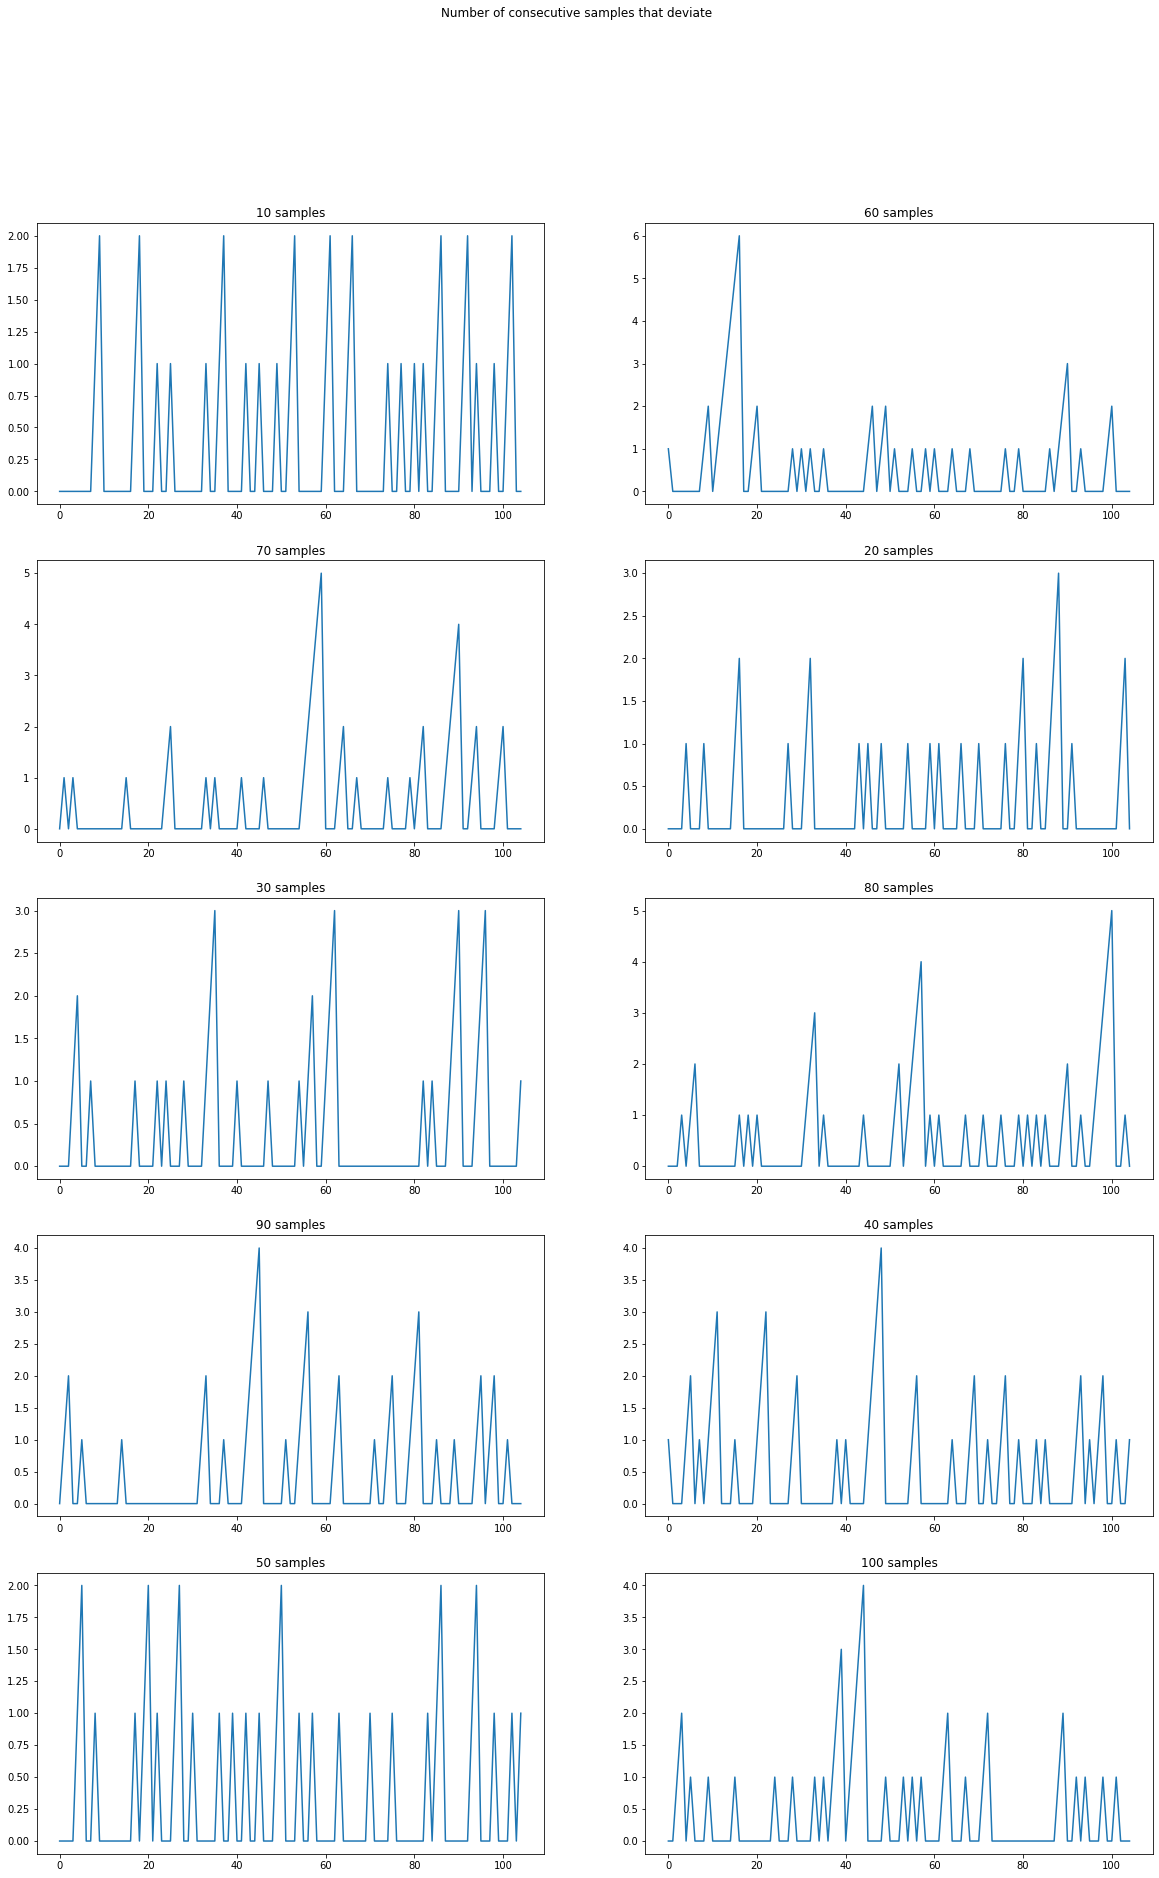

[30.506057338940103, 31.90991325479787, 32.60490018379345, 33.263940630762356, 33.81455746922563, 34.4032892913285, 35.121966339056016, 36.07853585585723, 37.18000576901678, 38.661985339432086]
[1.3576483354915865, 0.900092134480331, 0.7974001036281216, 0.7424497154347209, 0.745236556368103, 0.8054960192346924, 0.8736923131667194, 1.0087808658388728, 1.1040179513053954, 1.4252296723323599]
[0.2396590454054529, 0.2524094038774061, 0.29243919254976797, 0.3262376664726399, 0.3290856600447997, 0.3464037965745493, 0.36456648683014786, 0.3338582684934928, 0.29345059183081396, 0.26650304142191916]
[0.1338790909971594, 0.0870581747151472, 0.08028445121383676, 0.08119516833104092, 0.0910499275760187, 0.0787327508596009, 0.06844494483619201, 0.06734089145482722, 0.06143988414486451, 0.05592602558064744]
(174, 100)
test data size = 174


10it [01:35,  9.58s/it]


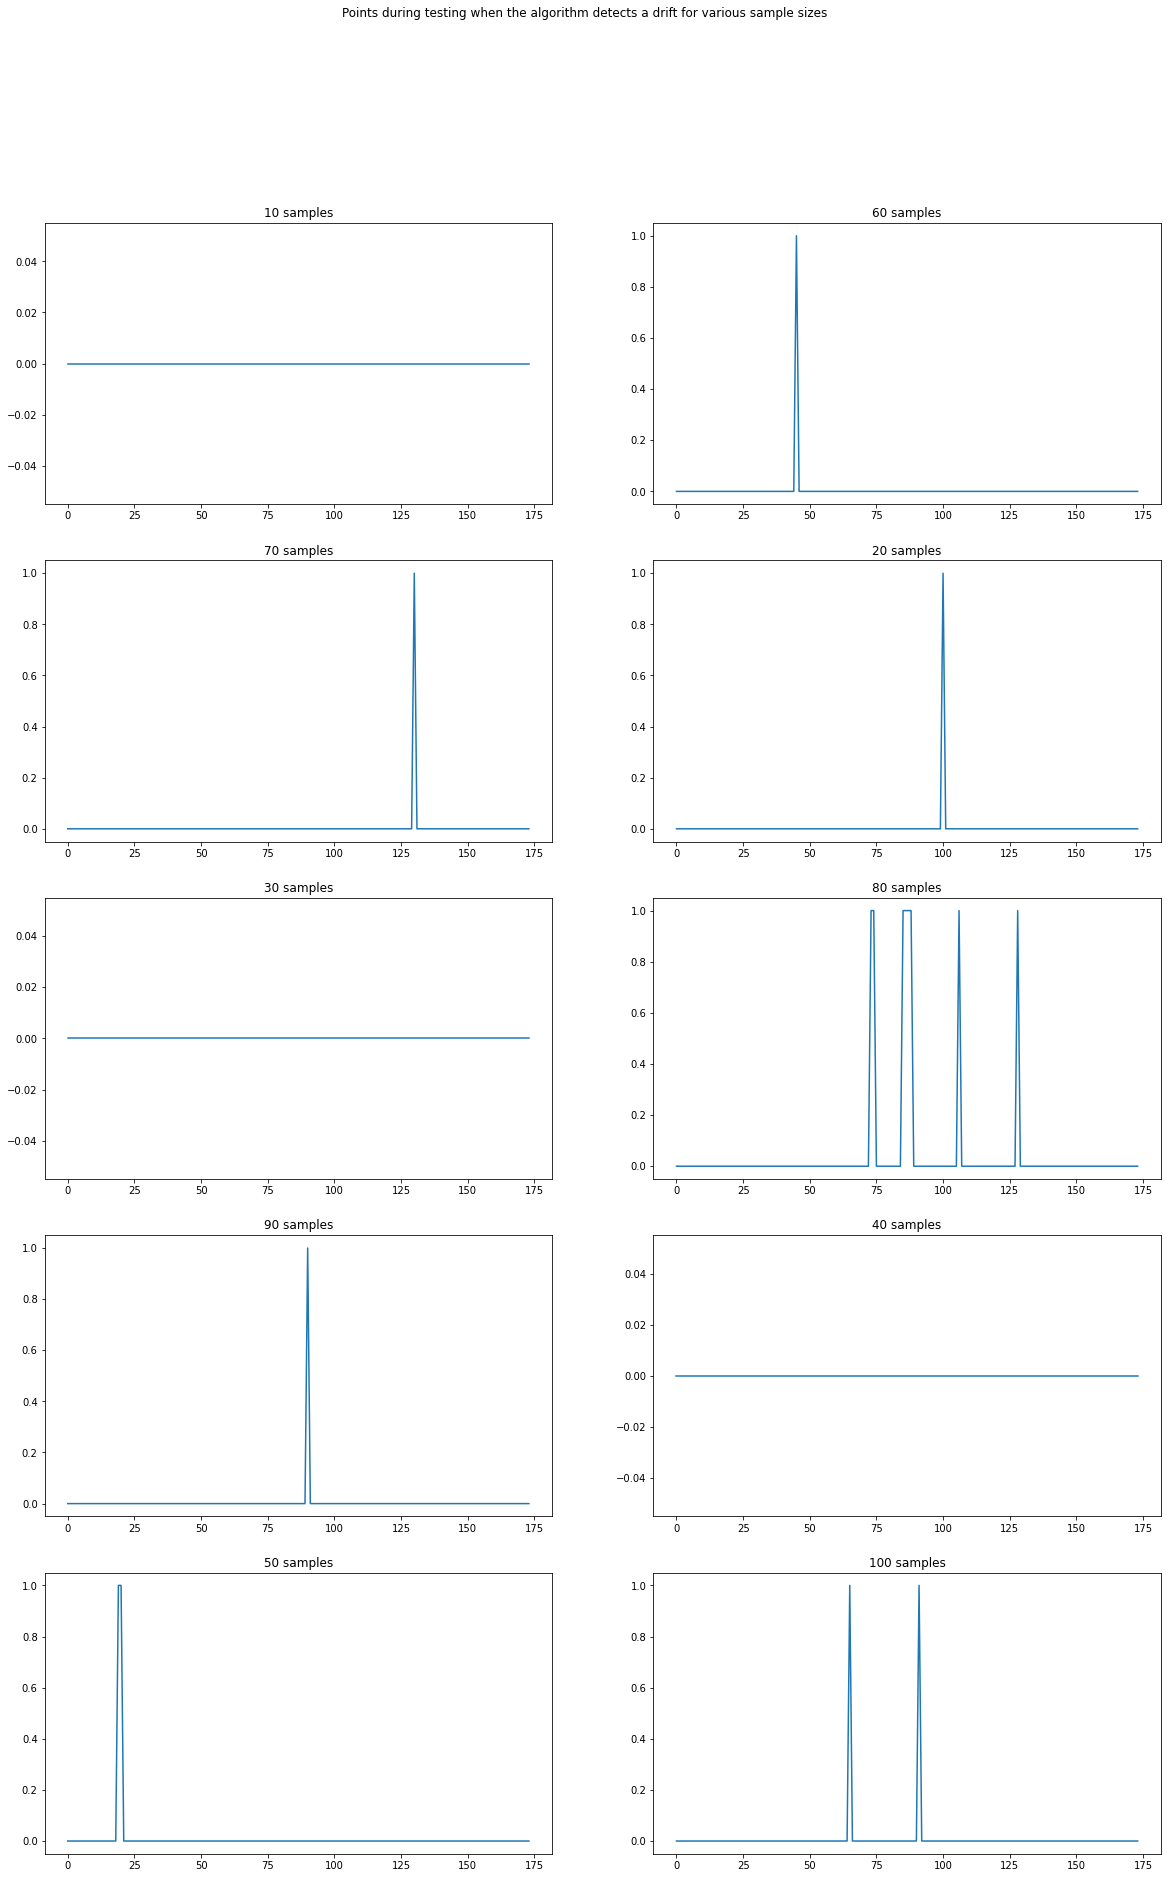

[29.942097311196505, 32.2253949323266, 32.95696588276282, 33.4865445938843, 34.03695572884196, 34.64143179734945, 35.36949786879732, 36.28742549472437, 37.32958254871237, 38.83379681071471]
[1.560917500076284, 0.9565796324942225, 0.7617387894887885, 0.8105403215192003, 0.8425238963026199, 0.9099750132011111, 0.9951224951092462, 1.0841598600354576, 1.1740384395846484, 1.4475758952596667]
[0.3189183132489362, 0.28621470620685374, 0.29592086162107384, 0.3419982073142825, 0.33971518709358484, 0.37388456775131235, 0.3725854438965442, 0.35080960817599705, 0.3242984200454079, 0.2904766723718087]
[0.16972369246068478, 0.10326000838717979, 0.09852629871858307, 0.09065008306038938, 0.08364157497173501, 0.07994508017805775, 0.07814670750861338, 0.07163883809361375, 0.06660264010477517, 0.06747276703094554]


In [11]:
import pandas as pd

fig, ax = plt.subplots(len(paths_1)//2, 2, figsize = (15, 25))
fig.suptitle("Plots of response under standard conditions")
for i,path in enumerate(paths_1):
    db = pd.read_csv(path, usecols=[3, 4, 10], header = None, names = ["time", "input", "output"])
    db = db[db["time"] > 0]
    ax[i%(len(paths_1)//2)][i%2].plot(db["time"], db["input"])
    ax[i%(len(paths_1)//2)][i%2].plot(db["time"], db["output"])
    ax[i%(len(paths_1)//2)][i%2].set_title(path[-14:-8])

plt.show()

fig, ax = plt.subplots(len(paths_2)//2, 2, figsize = (15, 25))
fig.suptitle("Plots of response under rivet hole")
for i,path in enumerate(paths_2):
    db = pd.read_csv(path, usecols=[3, 4, 10], header = None, names = ["time", "input", "output"])
    db = db[db["time"] > 0]
    ax[i%(len(paths_1)//2)][i%2].plot(db["time"], db["input"])
    ax[i%(len(paths_1)//2)][i%2].plot(db["time"], db["output"])
    ax[i%(len(paths_1)//2)][i%2].set_title(path[-14:-8])

plt.show()


patch_size = 100
num_components = 5
for i in range(0, len(paths_1), 2):
    db = pd.read_csv(paths_1[i], usecols=[3, 4, 10], header = None, names = ["time", "input", "output"])
    db = db[db["time"] > 0]
    db2 = pd.read_csv(paths_1[i+1], usecols=[3, 4, 10], header = None, names = ["time", "input", "output"])
    db2 = db2[db2["time"] > 0]
    db3 = pd.concat([db, db2], axis = 0, ignore_index = True)
    model, n_train, test_data, A_, thresholds = train_GMM_to_data(db3, int(paths_1[i][-10:-8]), patch_size, num_components, 5)
    reconstruct_test_data(model, A_, test_data, int(paths_1[i][-10:-8]), patch_size, num_components, n_train, thresholds, "clean")

    # generate test data
    db = pd.read_csv(paths_2[i], usecols=[3,4,10], header = None, names = ["time", "input", "output"])
    db = db[db["time"] > 0]
    db2 = pd.read_csv(paths_2[i+1], usecols=[3,4,10], header = None, names = ["time", "input", "output"])
    db2 = db2[db2["time"] > 0]
    db3 = pd.concat([db, db2], axis = 0, ignore_index = True)
    rivet_test_data = get_rivet_data(db3, int(paths_2[i][-10:-8]), patch_size)
    reconstruct_test_data(model, A_, rivet_test_data, int(paths_2[i][-10:-8]), patch_size, num_components, n_train, thresholds, "rivet")

## Updating gmm in x-domain once drift is detected

In [13]:
# now consider only one temperature and one sample size
# introduction on drift in the generating distribution

patch_size = 100
temp = 35
num_components = 5
m = (patch_size * 5)/10 # half the measurements
# train model on the given patch_size and temperature

db = pd.read_csv(paths_1[2], usecols=[3, 4, 10], header = None, names = ["time", "input", "output"]) # 35C
db = db[db["time"] > 0]
db2 = pd.read_csv(paths_1[3], usecols=[3, 4, 10], header = None, names = ["time", "input", "output"]) # 35C
db2 = db2[db2["time"] > 0]
db3 = pd.concat([db, db2], axis = 0, ignore_index = True)
model, n_train, test_data, A_, thresholds = train_GMM_to_data(db3, temp, patch_size, num_components, 5)


# generate test data
db = pd.read_csv(paths_2[2], usecols=[3,4,10], header = None, names = ["time", "input", "output"])
db = db[db["time"] > 0]
db2 = pd.read_csv(paths_2[3], usecols=[3,4,10], header = None, names = ["time", "input", "output"])
db2 = db2[db2["time"] > 0]
db3 = pd.concat([db, db2], axis = 0, ignore_index = True)
rivet_test_data = get_rivet_data(db3, int(paths_2[2][-10:-8]), patch_size)
# reconstruct_test_data(model, A_, rivet_test_data, int(paths_2[i][-10:-8]), patch_size, num_components, n_train, thresholds, "rivet")


def update_GMM_x(model, new_data, patch_size, threshold, n_train):
    batch = 174
    N = n_train
    d = patch_size
    for ii in range(len(new_data)//batch):
        avg_cost = 0
        ks = []
        for i in range(ii,ii+batch):
            x = new_data[i]
            cost = []
            for j in range(model.means_.shape[0]):
                var_j, mu_j = model.covariances_[j], model.means_[j]
                cost_j = weighted_l2(x - mu_j, var_j) + np.log(np.linalg.det(var_j))
                cost.append(cost_j)
            k = np.argmin(cost)
            ks.append(k)
            # print(cost[k])
            avg_cost += cost[k]
        avg_cost /= batch
        print(avg_cost)
        print(ks)

        if avg_cost < threshold:
            for i in range(ii,ii+batch):
                k = ks[i-ii]
                n = N*model.weights_[k]
                # print(k)
                # update rule
                z = (x-model.means_[k]).reshape(1,d)
                var = z.T @ z
                # var = np.diag((z.reshape(-1) ** 2))
                # print(z.shape, var.shape)
                # print(np.linalg.matrix_rank(var))
                model.covariances_[k] = n*(model.covariances_[k])/(n+1) + n*var/((n+1)**2)
                model.means_[k] += (x-model.means_[k])/(n+1)
                model.weights_ *= N
                model.weights_[k] += 1
                model.weights_ /= N+1
                N += 1
        else:
            print("new component")
            mu = np.mean(test_data[ii:ii+batch], axis=0)
            z = (test_data[ii:ii+batch] - mu)
            # var = z.T @ z / batch
            var = np.diag((z ** 2).mean(axis=0))
            var += 1e-6 * np.eye(d)
            # print("var shape", var.shape)
            print("var rank", np.linalg.matrix_rank(var))
            model.means_ = np.append(model.means_, mu.reshape(1,-1), axis=0)
            model.covariances_ = np.append(model.covariances_, var.reshape(1,d,d), axis=0)
            model.weights_ = np.append(model.weights_, [batch/N], axis=0)
            model.weights_ *= N/(N+batch)
            N += batch

update_GMM_x(model, rivet_test_data, patch_size, thresholds[4], n_train)

train data samples = 6959
test data samples = 10440
test data samples (non-overlapping) = 105
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 3
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 4
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True


100%|██████████| 10/10 [00:37<00:00,  3.76s/it]


[31.562332269317615, 33.10233986767548, 34.36321712697299, 35.15997937566166, 35.79734752520274, 36.44256187791549, 37.18018940891387, 38.04178635238856, 39.28335537766192, 40.793562673104105]
[1.7111845378129662, 1.2982212392640753, 0.9025384616042061, 0.7713592912955992, 0.6919483237575215, 0.7313664115296858, 0.9169662213034562, 1.0662309364215632, 1.1595910966655447, 1.396829170633463]
[0.19914935226959463, 0.2903587739612987, 0.29545082820741597, 0.30995491305966383, 0.3020862857661687, 0.32378483940074504, 0.33770036132659326, 0.3205149160971701, 0.30245160034031876, 0.2946807025433127]
[0.09482095558066063, 0.11348485571285286, 0.10054555683140505, 0.08633600570411111, 0.06466323663623154, 0.06384788743317064, 0.07499408880913183, 0.06590190789413529, 0.06132964329285705, 0.07644641594176892]
(174, 100)
test data size = 174
-589.0012974650256
[0, 3, 4, 0, 0, 2, 4, 4, 4, 4, 0, 4, 1, 0, 4, 2, 2, 2, 0, 1, 2, 2, 4, 4, 1, 0, 4, 2, 0, 4, 0, 4, 1, 4, 3, 1, 2, 1, 2, 3, 0, 2, 1, 4, 1, 3,

In [119]:
# using pca as a sparsifying matrix
# make a gmm by training on random data. Perform pca on the same data, take compressed measurements reconstruct and compare
# Use the error in the last part as a measure of threshold
# shift mean of gmm, generate data, reconstruct and compare using old pca basis. Check error
from sklearn.decomposition import PCA


n_samples = 10000
dim = 20
sample_data = np.random.rand(n_samples, dim)*10 - 5
# print(np.mean(sample_data, axis=0))
sample_data = sample_data - np.mean(sample_data, axis=0)
# model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
# model.fit(sample_data)
pca = PCA(n_components=dim)
pca.fit(sample_data)

# print(pca.mean_)
# print(np.mean(sample_data, axis=0))
# ensured zero mean data


[-8.43769499e-18 -1.65201186e-16 -3.91187083e-17 -4.68514116e-17
 -9.84545778e-17  1.72573067e-16 -2.55795385e-17  1.48436818e-17
  1.37712064e-16  7.66497976e-17 -7.55839835e-17  3.42836870e-17
 -1.95399252e-18  2.38919995e-17 -6.48370246e-18  7.97140132e-18
  1.23367982e-16 -1.01429976e-16  2.09610107e-17 -9.87654403e-17]
[-8.43769499e-18 -1.65201186e-16 -3.91187083e-17 -4.68514116e-17
 -9.84545778e-17  1.72573067e-16 -2.55795385e-17  1.48436818e-17
  1.37712064e-16  7.66497976e-17 -7.55839835e-17  3.42836870e-17
 -1.95399252e-18  2.38919995e-17 -6.48370246e-18  7.97140132e-18
  1.23367982e-16 -1.01429976e-16  2.09610107e-17 -9.87654403e-17]


In [120]:
from sklearn.linear_model import OrthogonalMatchingPursuitCV


g = pca.transform(sample_data[0:2])
pca.components_.shape
# print((np.linalg.inv(pca.components_) @ g.T).T + pca.mean_)
# print(sample_data[0:2])
# print(g)
# np.linalg.inv(pca.components_) @ g
A_ = np.random.binomial(1, 0.5, (dim//2, dim)) @ pca.components_
compressed_measurements = (A_ @ sample_data - (sample_data.mean(axis=0)).T).T


omp = OrthogonalMatchingPursuitCV(normalize=False)
omp.fit(A_, compressed_measurements[0])
omp.coef_


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10000 is different from 20)

In [121]:
print(np.linalg.inv(pca.components_) @ omp.coef_ + pca.mean_)
print(sample_data[0])
print(np.linalg.norm(np.linalg.inv(pca.components_) @ omp.coef_ + pca.mean_ - sample_data[0]))

[ 0.20925917 -1.23044365  0.92080765 -2.03529291  1.05782519 -1.38838547
  0.09675016 -3.031064   -1.97483854 -1.01067083  1.38633592  1.04121547
 -2.90621091 -1.0220004  -0.68955017 -0.96454683 -0.5943457  -1.40102983
 -1.14238137  0.42795947]
[ 2.65744522  4.9820723   0.57561232 -0.90310237  0.40188413  1.09354572
 -2.31987803 -0.85145385  1.61910143 -2.88322036 -0.99159028 -0.71184822
  1.49211297  1.70096542 -4.65349086 -4.24377517  0.50815567 -2.71905006
 -2.27058425  4.4601526 ]
12.729167266649883


In [115]:
import cvxpy as cp

for i in range(-5, 5):

    recon = cp.Variable(dim)
    lmd = 10**i
    objective = cp.Minimize(cp.norm(A_ @ (recon - pca.mean_) - compressed_measurements[0]) + lmd*cp.norm(recon, 1))
    prob = cp.Problem(objective)
    prob.solve()
    if i == 4:
        print(np.linalg.inv(pca.components_) @ recon.value + np.mean(sample_data, axis=0))
        print(sample_data[0])
    print(np.linalg.norm(np.linalg.inv(pca.components_) @ recon.value + np.mean(sample_data, axis=0) - sample_data[0]))

14.49706235830817
14.497075941455119
14.497075814287479
14.497076768419372
14.497076771690754
14.275413501093023
11.813285174353691
11.813285174311565
11.81328517431098
[-5.50955821e-13  2.07207741e-13 -3.47923271e-13  1.81409649e-13
  1.78225321e-13 -7.74185244e-14  1.09617118e-13  2.74079449e-13
 -2.59555735e-13 -9.79119573e-13  4.30459044e-13 -3.51465653e-13
 -2.33970116e-13 -8.80619804e-14 -3.04144460e-13  2.23044585e-13
  2.74095898e-13 -1.20311306e-13  1.01879575e-13 -2.49356297e-13]
[ 1.58943702 -1.68264824  2.94364762 -2.3566574   2.10070978  3.78393309
 -2.35237772  4.5955069  -2.57724446 -1.59009679 -0.22802508  1.1966884
  0.41302571  3.64531363 -4.61597812  4.11043587  1.81928001 -1.76592552
 -2.16137993 -1.08506698]
11.813285174310934
